#### 1.  Packages

In [93]:
import pandas as pd
import numpy as np
import sys

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

pd.options.mode.chained_assignment = None  # default='warn'

In [197]:
#common training code
#to import common file
sys.path.insert(1, 'common')
import dimensionreduction_common as diredux
import score_common as score

# when any outside python is updated, run the following to reload the new version
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2.  Variables

In [172]:
TAACF = 'TAACF'
MLSMR = 'MLSMR'

data_path = 'ignore/data/'
image_path = "ignore\\images\\"
model_path = 'ignore/model/'

image_path_pca = f"{image_path}PCA\\"
data_path_pca = f'{data_path}PCA/'
font_path = 'common/Fonts/calibrib.ttf'
image_path_umap = f"{image_path}UMAP\\"
data_path_umap = f'{data_path}UMAP/'

suffix_TAACF = '_TS'
suffix_MLSMR = '_M'
suffix_Combined = '_C'
origin_TS = 1
origin_M = 2

col_smiles = 'SMILES'
col_inhibition = 'Inhibition'
col_Activity = 'Activity'
col_origin = 'Origin'
col_NonDescriptors_legacycode = [col_smiles, col_inhibition]
col_nonFeatures = [col_smiles, col_Activity, col_inhibition]

filename_descriptors_scaled = f'featuresScaled'

#### 3.  Load Data

##### &nbsp;&nbsp;&nbsp;3.1&nbsp;&nbsp;Load datasets

In [103]:
# TAACF
# --------------------------------------------------------------------------------------------
data_features_taacf = pd.read_csv(f'{data_path}{filename_descriptors_scaled}{suffix_TAACF}.csv', index_col=0)
data_y_taacf = pd.read_csv(f"{data_path}y{suffix_TAACF}.csv", index_col=0)
data_molecules_taacf = pd.read_csv(f"{data_path}Molecules{suffix_TAACF}.csv", index_col=0) 

#add label to descriptors
data_taacf = pd.concat([data_molecules_taacf[col_smiles], data_y_taacf, data_molecules_taacf[col_inhibition], data_features_taacf], axis = 1)


# MLSMR
# --------------------------------------------------------------------------------------------
data_features_mlsmr = pd.read_csv(f'{data_path}{filename_descriptors_scaled}{suffix_MLSMR}.csv', index_col=0)
data_y_mlsmr = pd.read_csv(f"{data_path}y{suffix_MLSMR}.csv", index_col=0)
data_molecules_mlsmr = pd.read_csv(f"{data_path}Molecules{suffix_MLSMR}.csv", index_col=0) 

#add label to descriptors
data_mlsmr = pd.concat([data_molecules_mlsmr[col_smiles], data_y_mlsmr, data_molecules_mlsmr[col_inhibition], data_features_mlsmr], axis = 1)

C:\Users\frogi\AppData\Local\Temp\ipykernel_19720\4157094867.py:5: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_molecules_taacf = pd.read_csv(f"{data_path}Molecules{suffix_TAACF}.csv", index_col=0)
C:\Users\frogi\AppData\Local\Temp\ipykernel_19720\4157094867.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_molecules_mlsmr = pd.read_csv(f"{data_path}Molecules{suffix_MLSMR}.csv", index_col=0)


##### &nbsp;&nbsp;&nbsp;3.2&nbsp;&nbsp;Extract Actives

In [104]:
# get actives
data_taacf_active = data_taacf.loc[data_taacf[col_Activity] == 1]
data_mlsmr_active = data_mlsmr.loc[data_mlsmr['Activity'] == 1]

#copy columns that are not features
data_taacf_active_ID = data_taacf_active[col_nonFeatures].copy()
data_mlsmr_active_ID = data_mlsmr_active[col_nonFeatures].copy()

# get y label
data_taacf_active_y = data_taacf_active[col_Activity].copy()
data_mlsmr_active_y = data_mlsmr_active[col_Activity].copy()

# drop non-feature columns
data_taacf_active_feature = data_taacf_active.drop(col_nonFeatures, axis=1)
data_mlsmr_active_feature = data_mlsmr_active.drop(col_nonFeatures, axis=1)

##### &nbsp;&nbsp;&nbsp;3.3&nbsp;&nbsp; Compare features from both datasets; keeping shared features

In [105]:
#get the features shared across both files
shared = np.intersect1d(data_taacf_active_feature.columns, data_mlsmr_active_feature.columns)
sharedFeatures = shared.tolist()
sharedFeatures.sort(key=str.casefold)

#get feature counts
feats_ts_count = data_taacf_active_feature.shape[1] 
feats_mlsmr_count = data_mlsmr_active_feature.shape[1]

#get shared features
feats_ts = data_taacf_active_feature.columns.tolist()
feats_mlsmr = data_mlsmr_active_feature.columns.tolist()

#get unshared features
unsharedFeatures = diredux.Diff(feats_ts, feats_mlsmr)

#analyze results
print('FEATURES:  TAACF-SRIKinase vs. MLSMR')
print('TAACF-SRIKinase: ' + str(feats_ts_count))
print('MLSMR: ' + str(feats_mlsmr_count))
print('Shared: ' + str(len(sharedFeatures)))
print('------------------------------------------------')
print(str(sharedFeatures))
print('\nUnshared: ' + str(len(unsharedFeatures)))
print('------------------------------------------------')
print(str(unsharedFeatures))

print('\nFeature Origin: ')
print('------------------------------------------------')

ts_feat_xtra = []
mlsmr_feat_xtra = []
for feat in unsharedFeatures:
    if feat in data_taacf_active_feature.columns:
        ts_feat_xtra.append(feat)
        print(f'dfTS_Active:  {feat}')
    
    if feat in data_mlsmr_active_feature.columns:
        mlsmr_feat_xtra.append(feat)
        print(f'dfMLSMR_Active:  {feat}')

FEATURES:  TAACF-SRIKinase vs. MLSMR
TAACF-SRIKinase: 80
MLSMR: 84
Shared: 79
------------------------------------------------
['a_acc', 'a_aro', 'a_don', 'a_donacc', 'a_hyd', 'a_nCl', 'a_nF', 'a_nN', 'a_nO', 'a_nS', 'apol', 'ast_violation', 'b_1rotN', 'b_double', 'b_max1len', 'chiral', 'diameter', 'h_ema', 'h_emd', 'h_emd_C', 'h_log_dbo', 'h_log_pbo', 'h_logD', 'h_logS', 'h_pKa', 'h_pKb', 'h_pstrain', 'Kier3', 'lip_acc', 'logP(o/w)', 'logS', 'opr_brigid', 'opr_nrot', 'opr_violation', 'PEOE_VSA+0', 'PEOE_VSA+1', 'PEOE_VSA+2', 'PEOE_VSA+3', 'PEOE_VSA+4', 'PEOE_VSA+5', 'PEOE_VSA+6', 'PEOE_VSA-0', 'PEOE_VSA-1', 'PEOE_VSA-2', 'PEOE_VSA-3', 'PEOE_VSA-4', 'PEOE_VSA-5', 'PEOE_VSA-6', 'PEOE_VSA_HYD', 'PEOE_VSA_NEG', 'PEOE_VSA_PNEG', 'PEOE_VSA_POL', 'PEOE_VSA_POS', 'PEOE_VSA_PPOS', 'SlogP', 'SlogP_VSA0', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'SMR_VSA0', 'SMR_VSA1', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VS

In [106]:
# use SelectKBest to get the top k features, to see if the unshared features are w/in the top k
# using training set to check
k = 50

#check taacf-srikinase
print('taacf-srikinase:  SelectKBest')
print('------------------------------')

print('f_classif: ')
diredux.check_SelectKBest(data_taacf_active_feature, data_taacf_active_y.to_numpy(), f_classif, k, ts_feat_xtra)

print('\nmutual_info_classif: ')
diredux.check_SelectKBest(data_taacf_active_feature, data_taacf_active_y.to_numpy(), mutual_info_classif, k, ts_feat_xtra)

taacf-srikinase:  SelectKBest
------------------------------
f_classif: 
Features did not rank in the top 50

mutual_info_classif: 
Features did not rank in the top 50


In [107]:
# use SelectKBest to get the top k features, to see if the unshared features are w/in the top k
# using training set to check

#check mlsmr
print('mlsmr:  SelectKBest')
print('------------------------------')

print('f_classif: ')
diredux.check_SelectKBest(data_mlsmr_active_feature, data_mlsmr_active_y.to_numpy(), f_classif, k, mlsmr_feat_xtra)

print('\nmutual_info_classif: ')
diredux.check_SelectKBest(data_mlsmr_active_feature, data_mlsmr_active_y.to_numpy(), mutual_info_classif, k, mlsmr_feat_xtra)

mlsmr:  SelectKBest
------------------------------
f_classif: 
PEOE_PC+ was ranked 3 in the top 50 most important features
vsa_base was ranked 46 in the top 50 most important features
weinerPath was ranked 50 in the top 50 most important features

mutual_info_classif: 
vsa_base was ranked 46 in the top 50 most important features
weinerPath was ranked 50 in the top 50 most important features


In [108]:
#keep only the shared columns across all datasets
# datasets with only actives
data_taacf_active_feature = data_taacf_active_feature[sharedFeatures]
data_mlsmr_active_feature = data_mlsmr_active_feature[sharedFeatures]

data_taacf_active = data_taacf_active[sharedFeatures]
data_mlsmr_active = data_mlsmr_active[sharedFeatures]

print(f'{TAACF} Actives feature count: {data_taacf_active_feature.shape}')
print(f'{MLSMR} Actives feature count: {data_mlsmr_active_feature.shape}')

TAACF Actives feature count: (3006, 79)
MLSMR Actives feature count: (3878, 79)


##### &nbsp;&nbsp;&nbsp;3.4&nbsp;&nbsp; Format datasets

In [109]:
#get list of column names and sort them alphabeltically
columns = data_taacf_active.columns.to_list()
columns.sort(key=str.casefold)

#change the order of the columns in all data sets
data_taacf_active = data_taacf_active.reindex(columns=columns)
data_mlsmr_active = data_mlsmr_active.reindex(columns=columns)
data_taacf_active_feature = data_taacf_active_feature.reindex(columns=columns)
data_mlsmr_active_feature = data_mlsmr_active_feature.reindex(columns=columns)

#add dataset origin column
data_taacf_active[col_origin] = origin_TS
data_mlsmr_active[col_origin] = origin_M

# keeping only shared features removes non-feature columns, so add them back in 
data_taacf_active = pd.concat([data_taacf_active_ID, data_taacf_active], axis = 1)
data_mlsmr_active = pd.concat([data_mlsmr_active_ID, data_mlsmr_active], axis = 1)

##### &nbsp;&nbsp;&nbsp;3.5&nbsp;&nbsp; Combine datasets with actives

In [189]:
#concatenate both files (rows)
data_active = pd.concat([data_taacf_active, data_mlsmr_active], axis=0)
data_active_y = data_active[col_Activity].copy()
data_active_origin = data_active[col_origin].copy()
data_active_inhibit = data_active[col_inhibition].copy()
data_active_smiles = data_active[col_smiles].copy()
data_active_feature = data_active.drop(col_nonFeatures, axis=1)

data_taacf_active_ = data_taacf_active.drop(col_nonFeatures, axis=1)
data_mlsmr_active_ = data_mlsmr_active.drop(col_nonFeatures, axis=1)
data_taacf_active_inhibit = data_taacf_active[col_inhibition].copy()
data_mlsmr_active_inhibit = data_mlsmr_active[col_inhibition].copy()
data_taacf_active_smiles = data_taacf_active[col_smiles].copy()
data_mlsmr_active_smiles = data_mlsmr_active[col_smiles].copy()

#### 4.  PCA

##### &nbsp;&nbsp;&nbsp;4.1&nbsp;&nbsp;Variance Ratio Scree Graph 

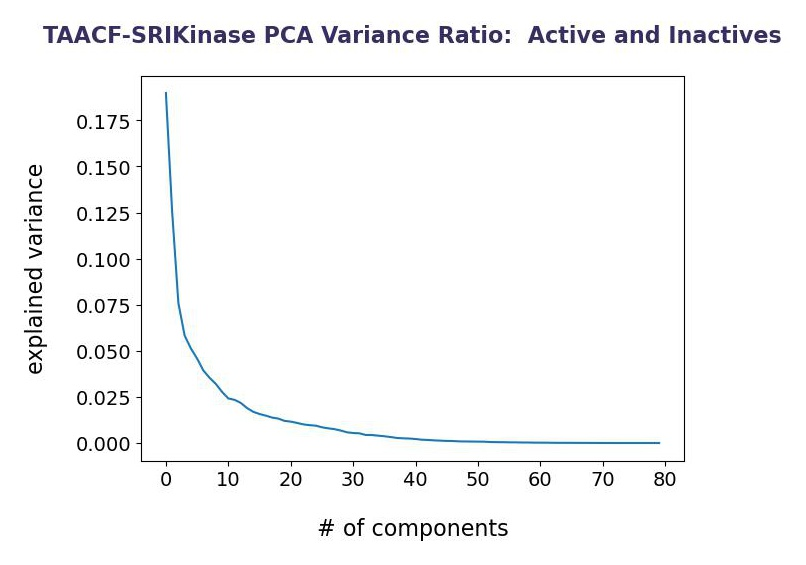

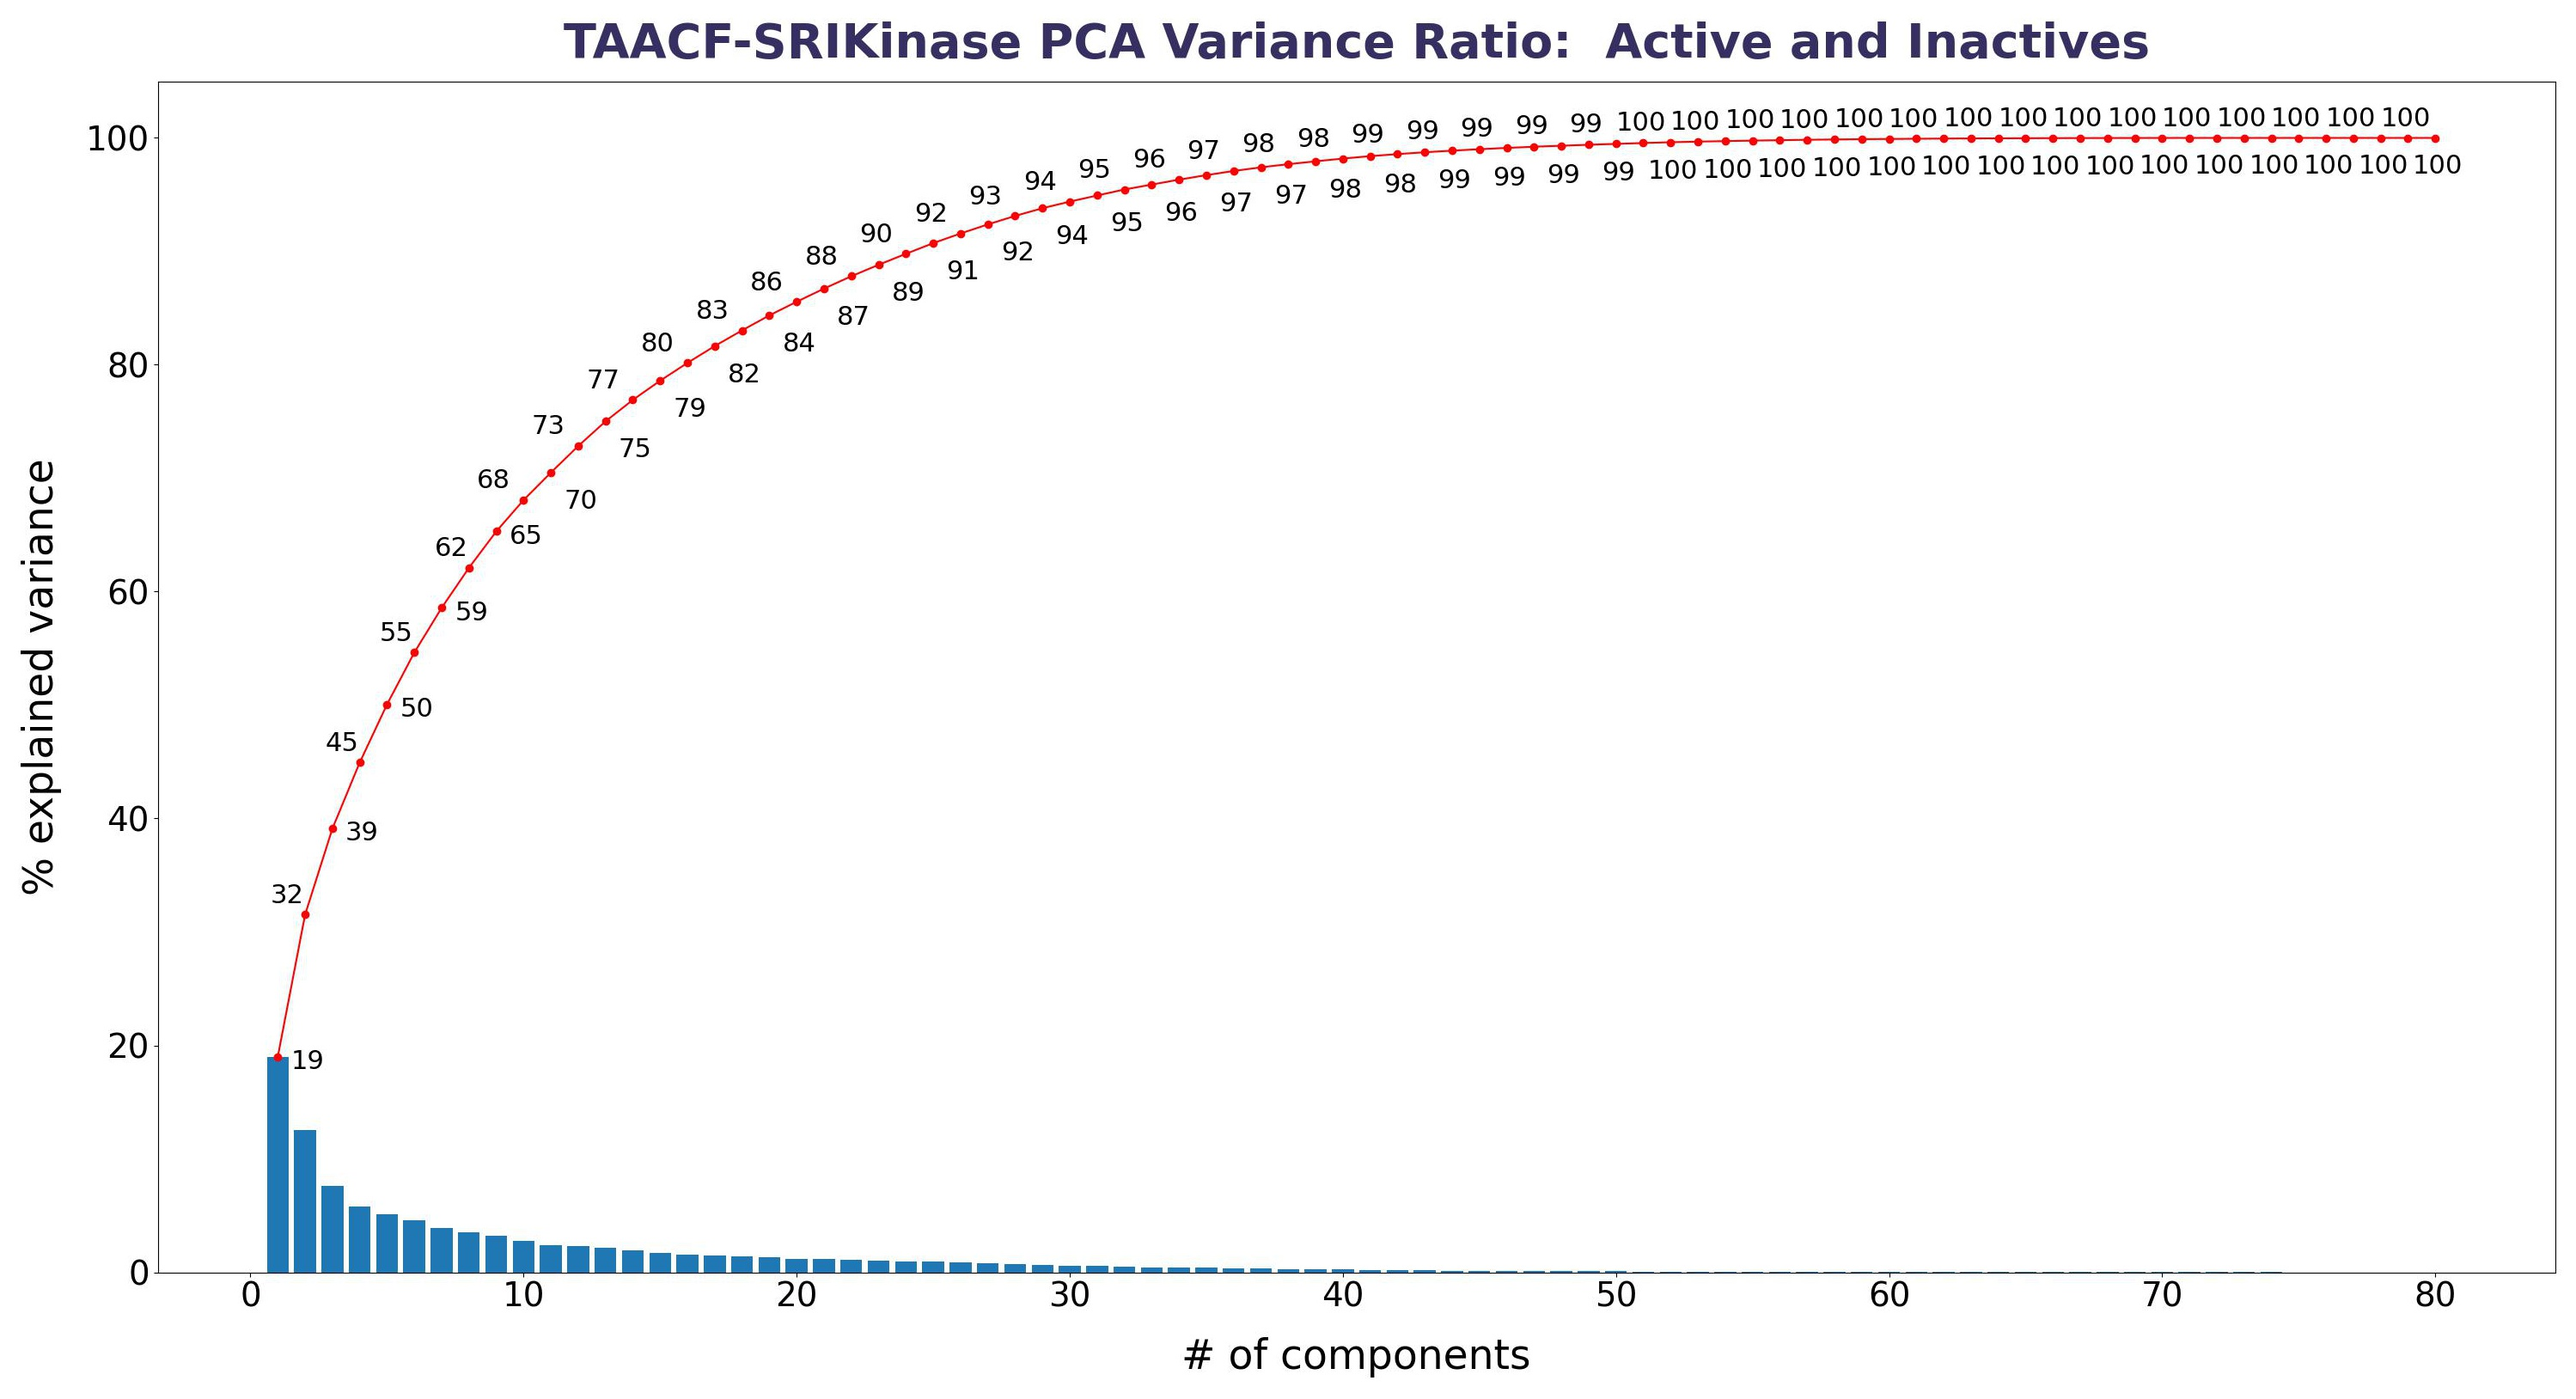

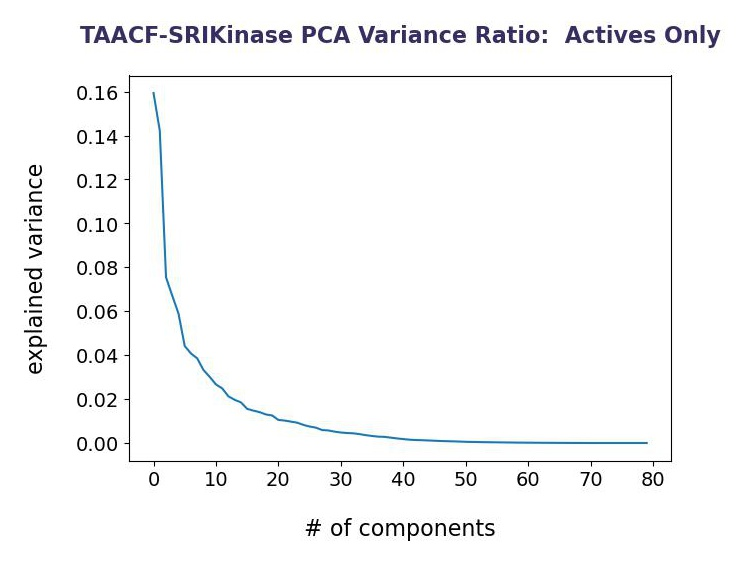

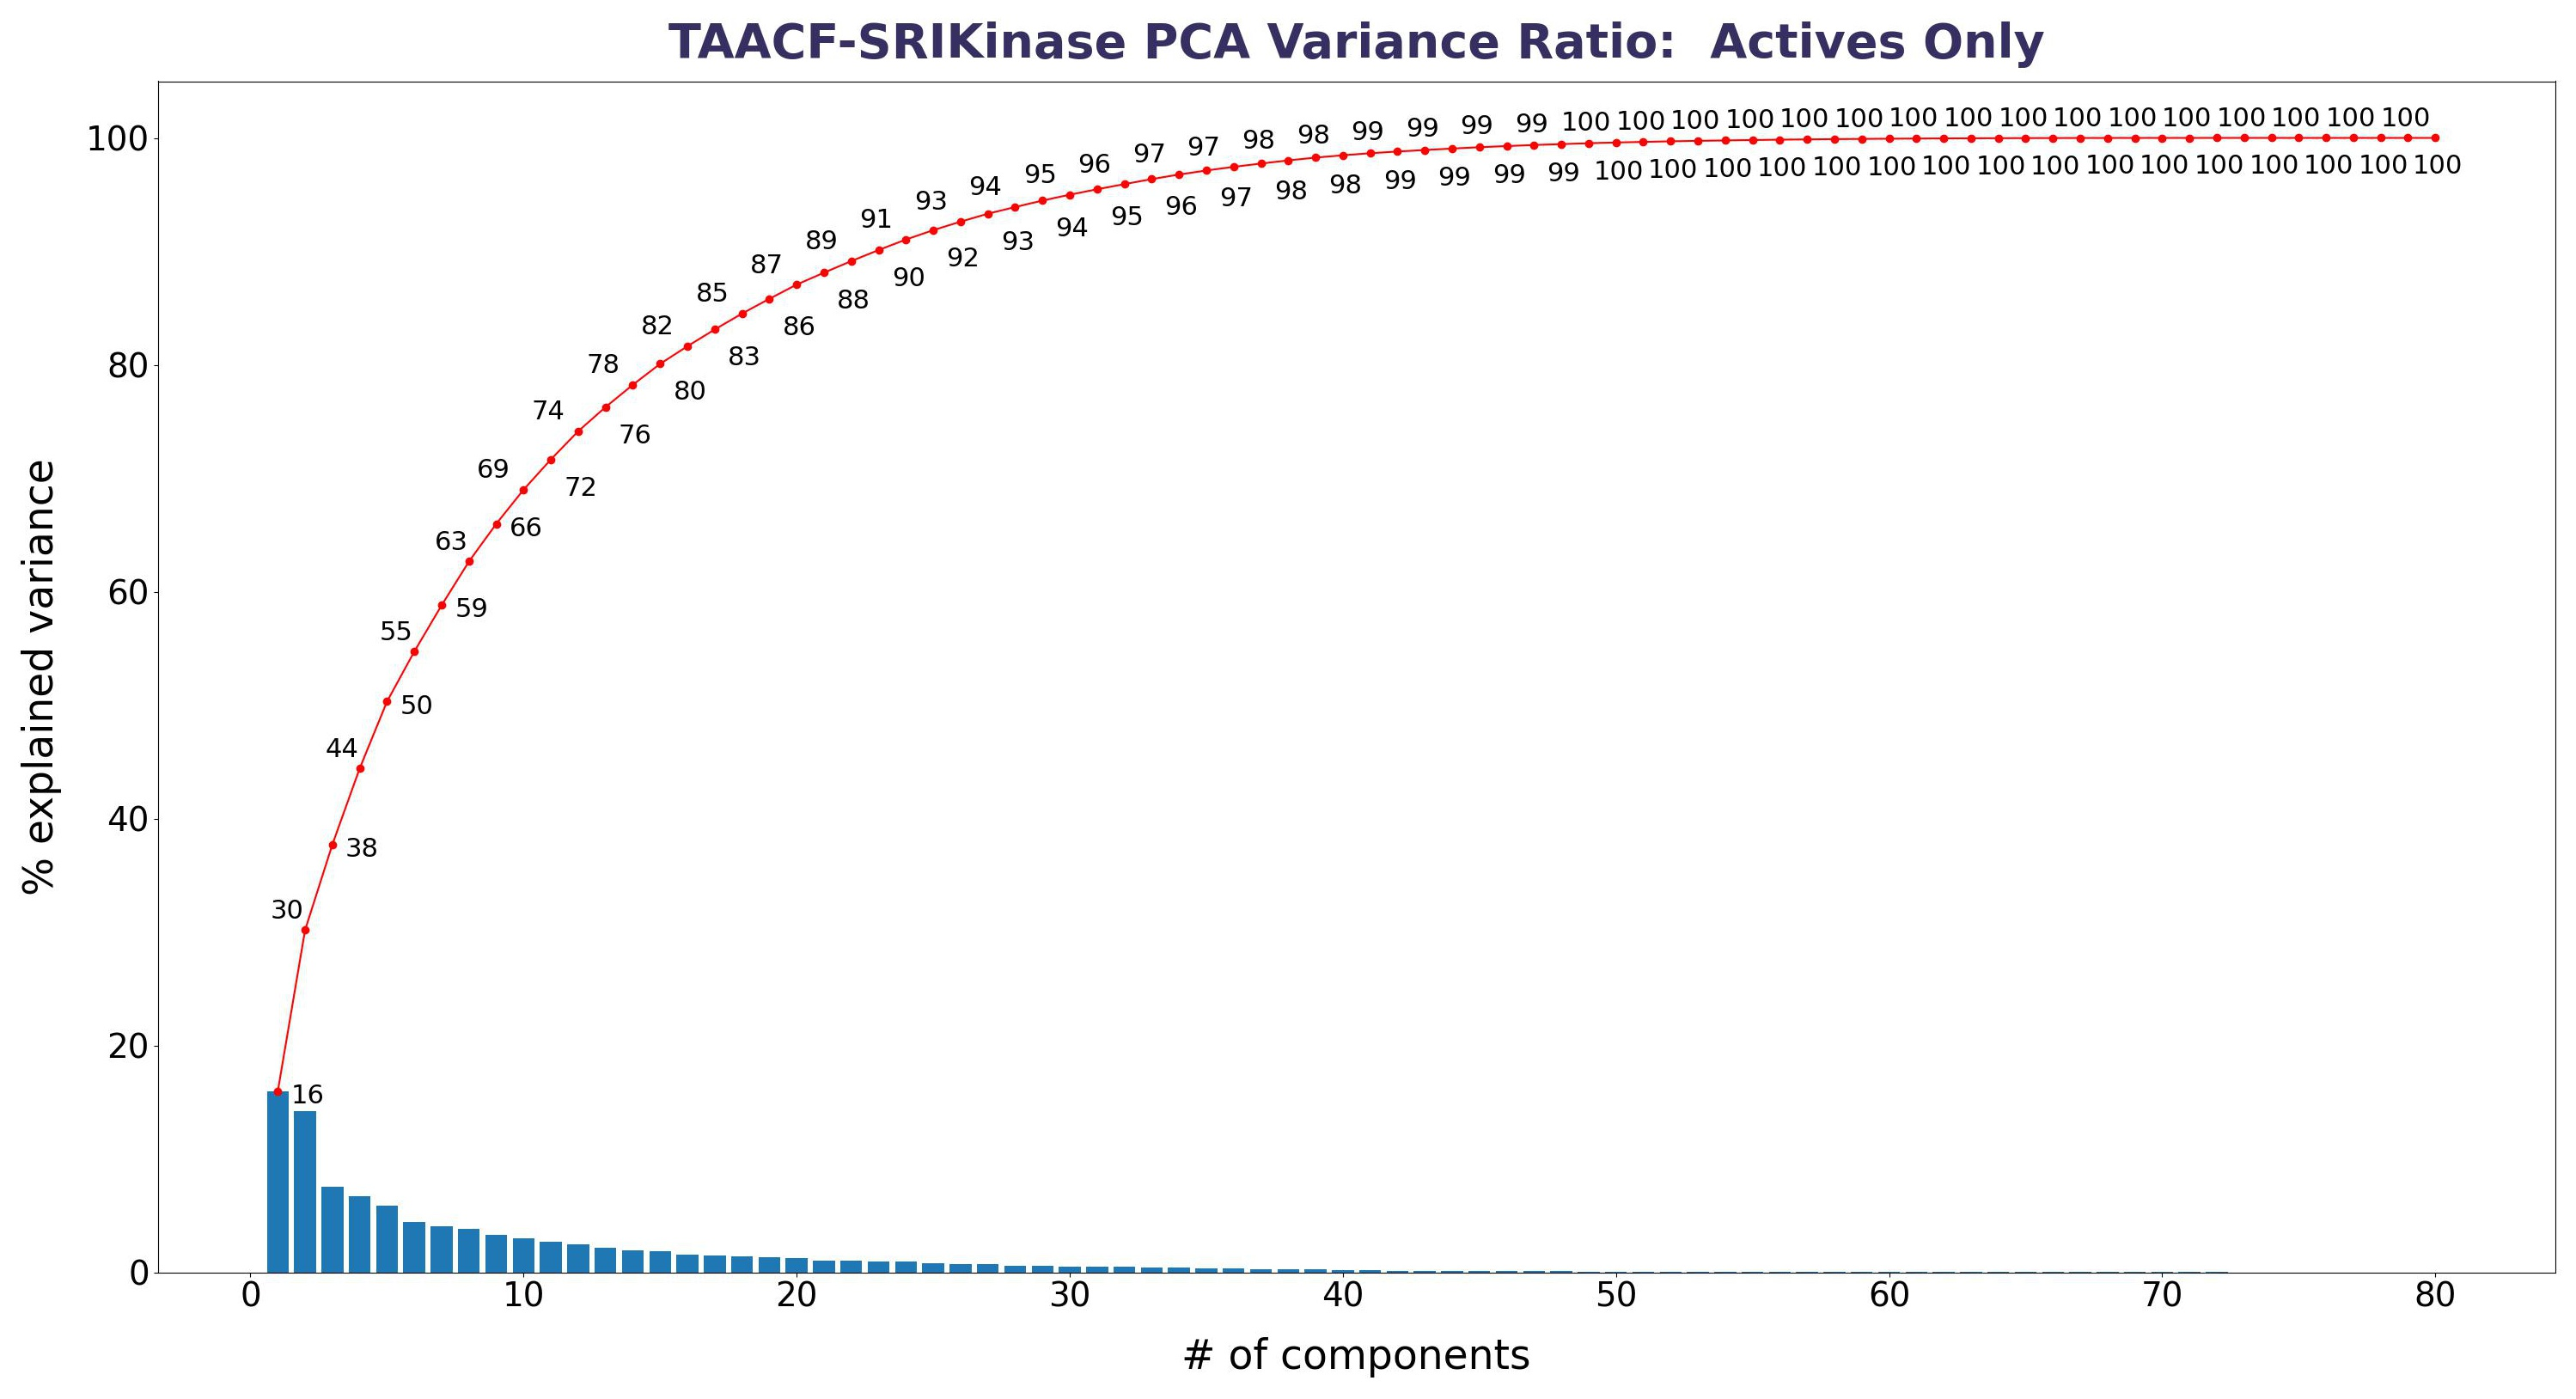

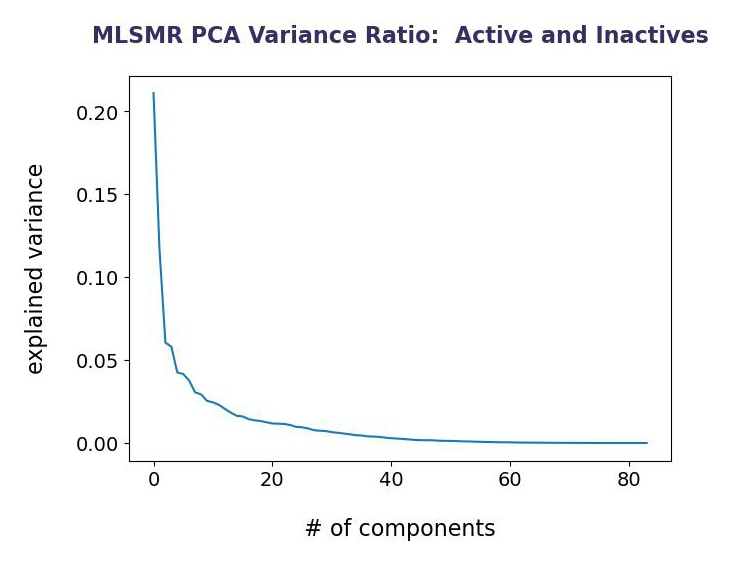

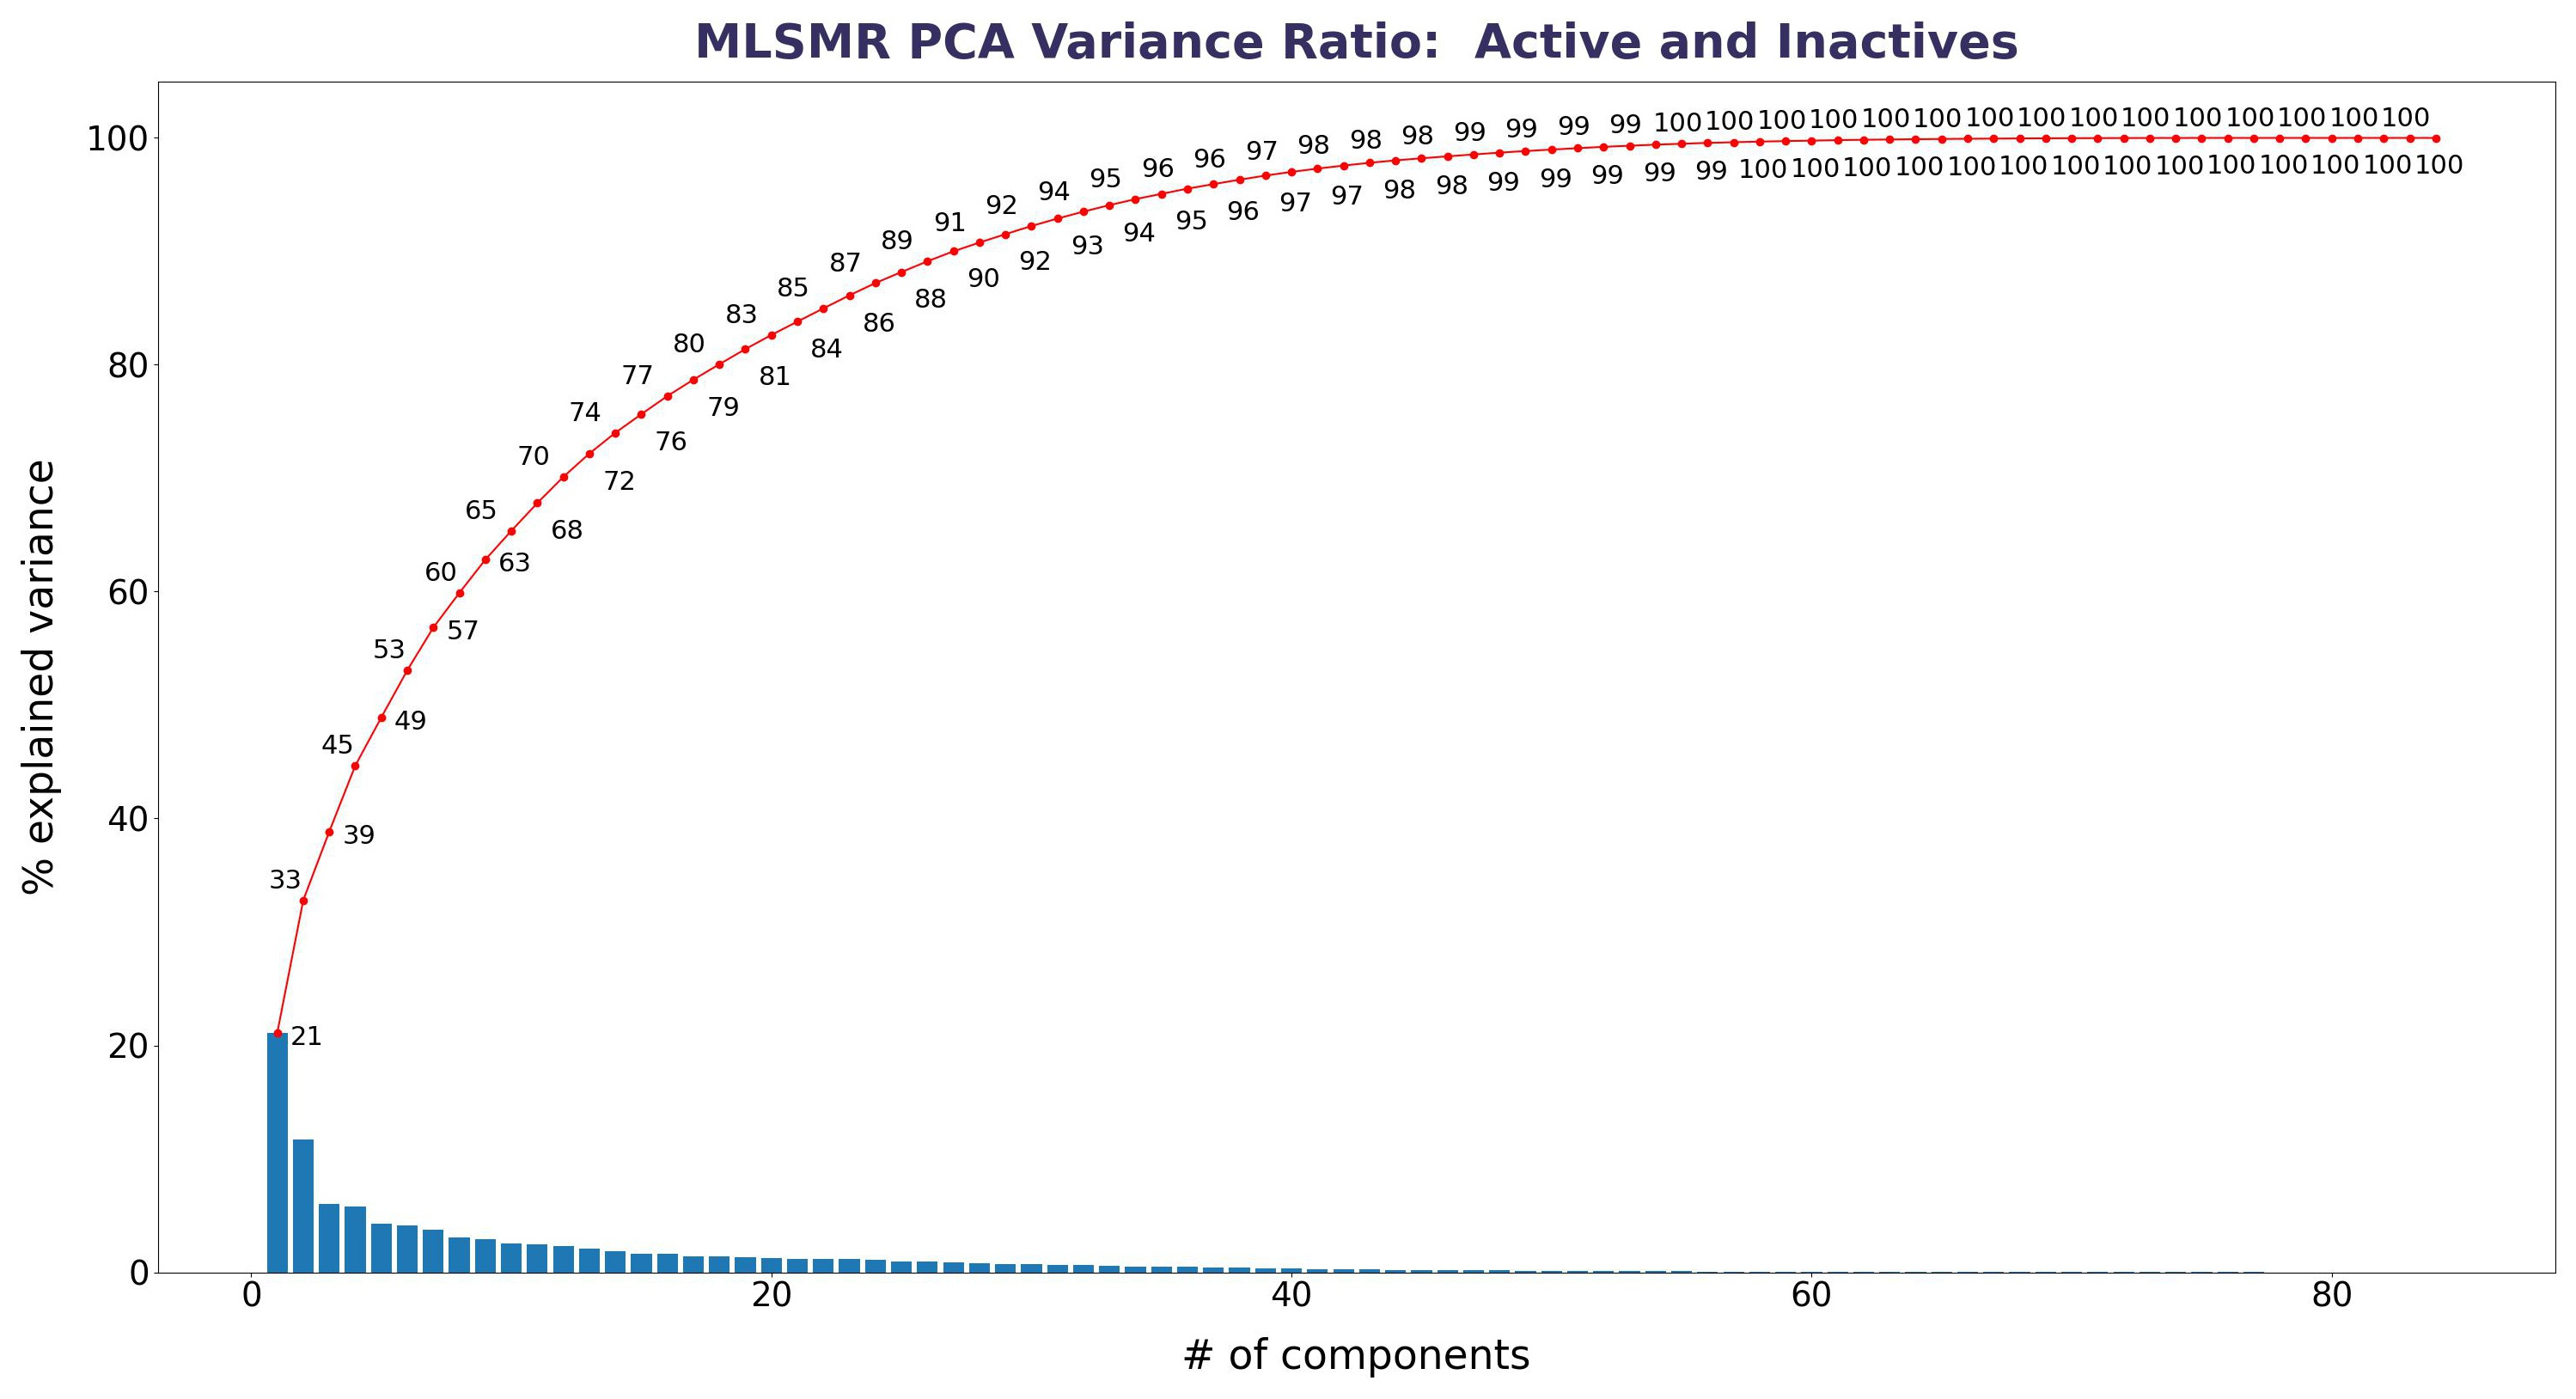

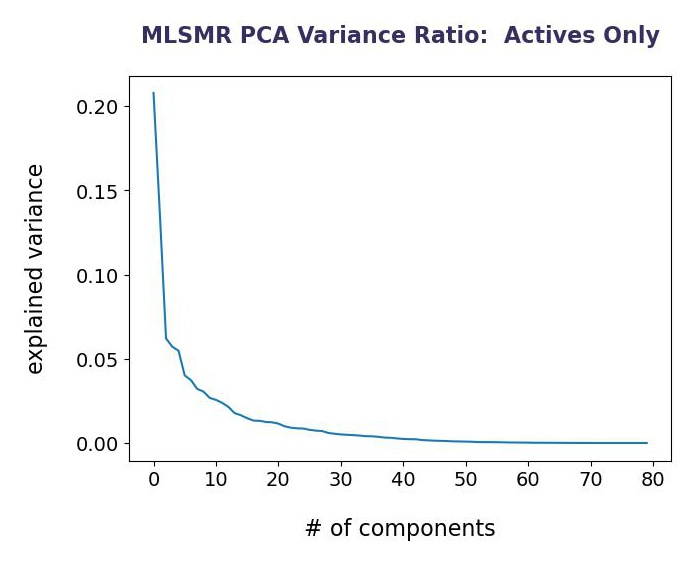

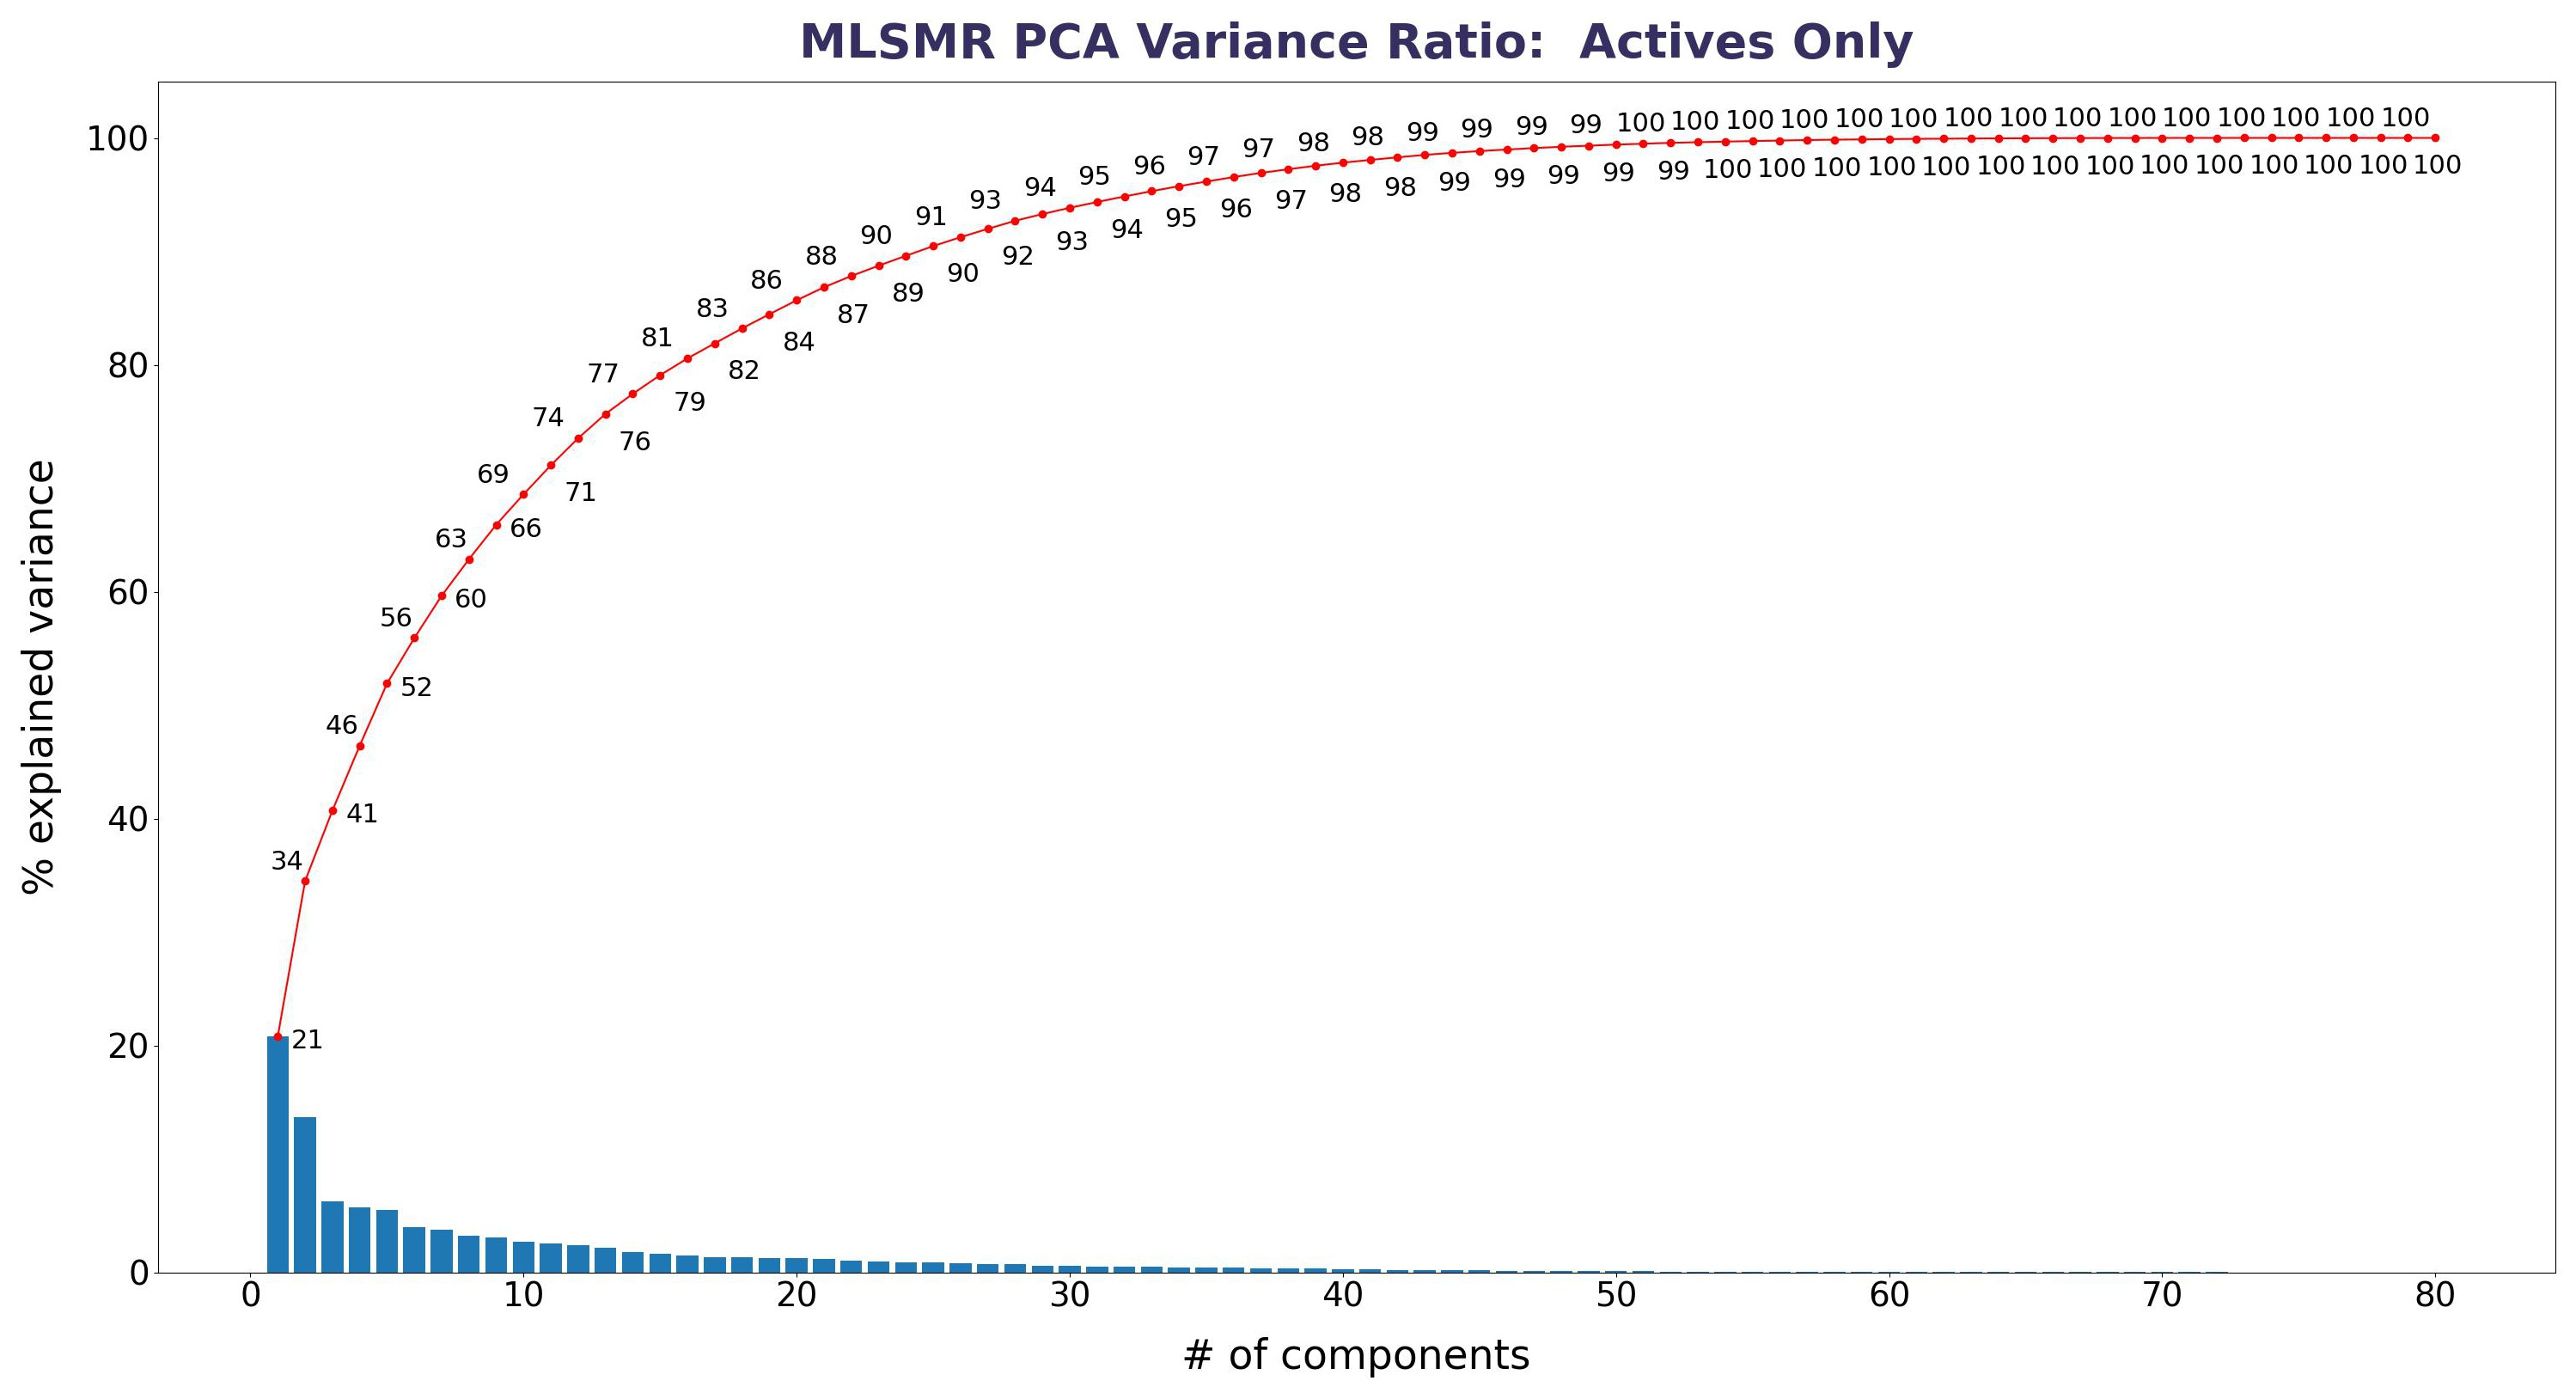

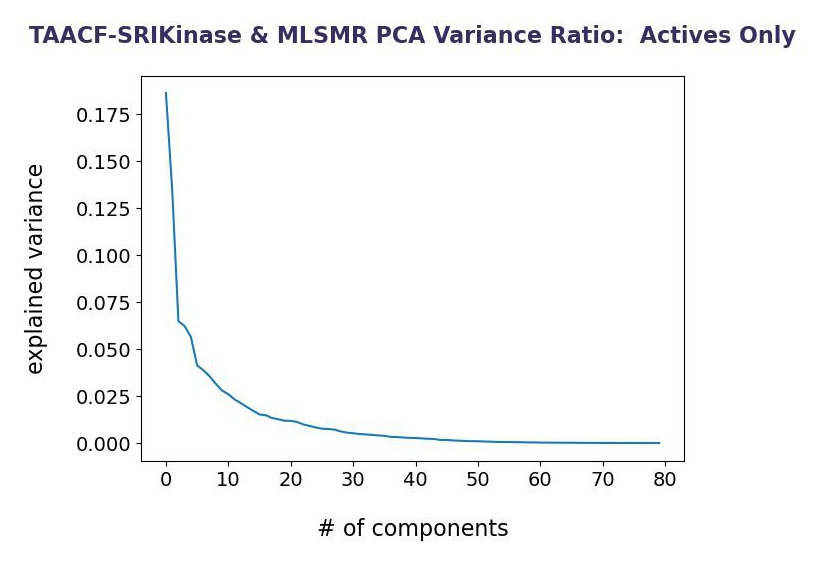

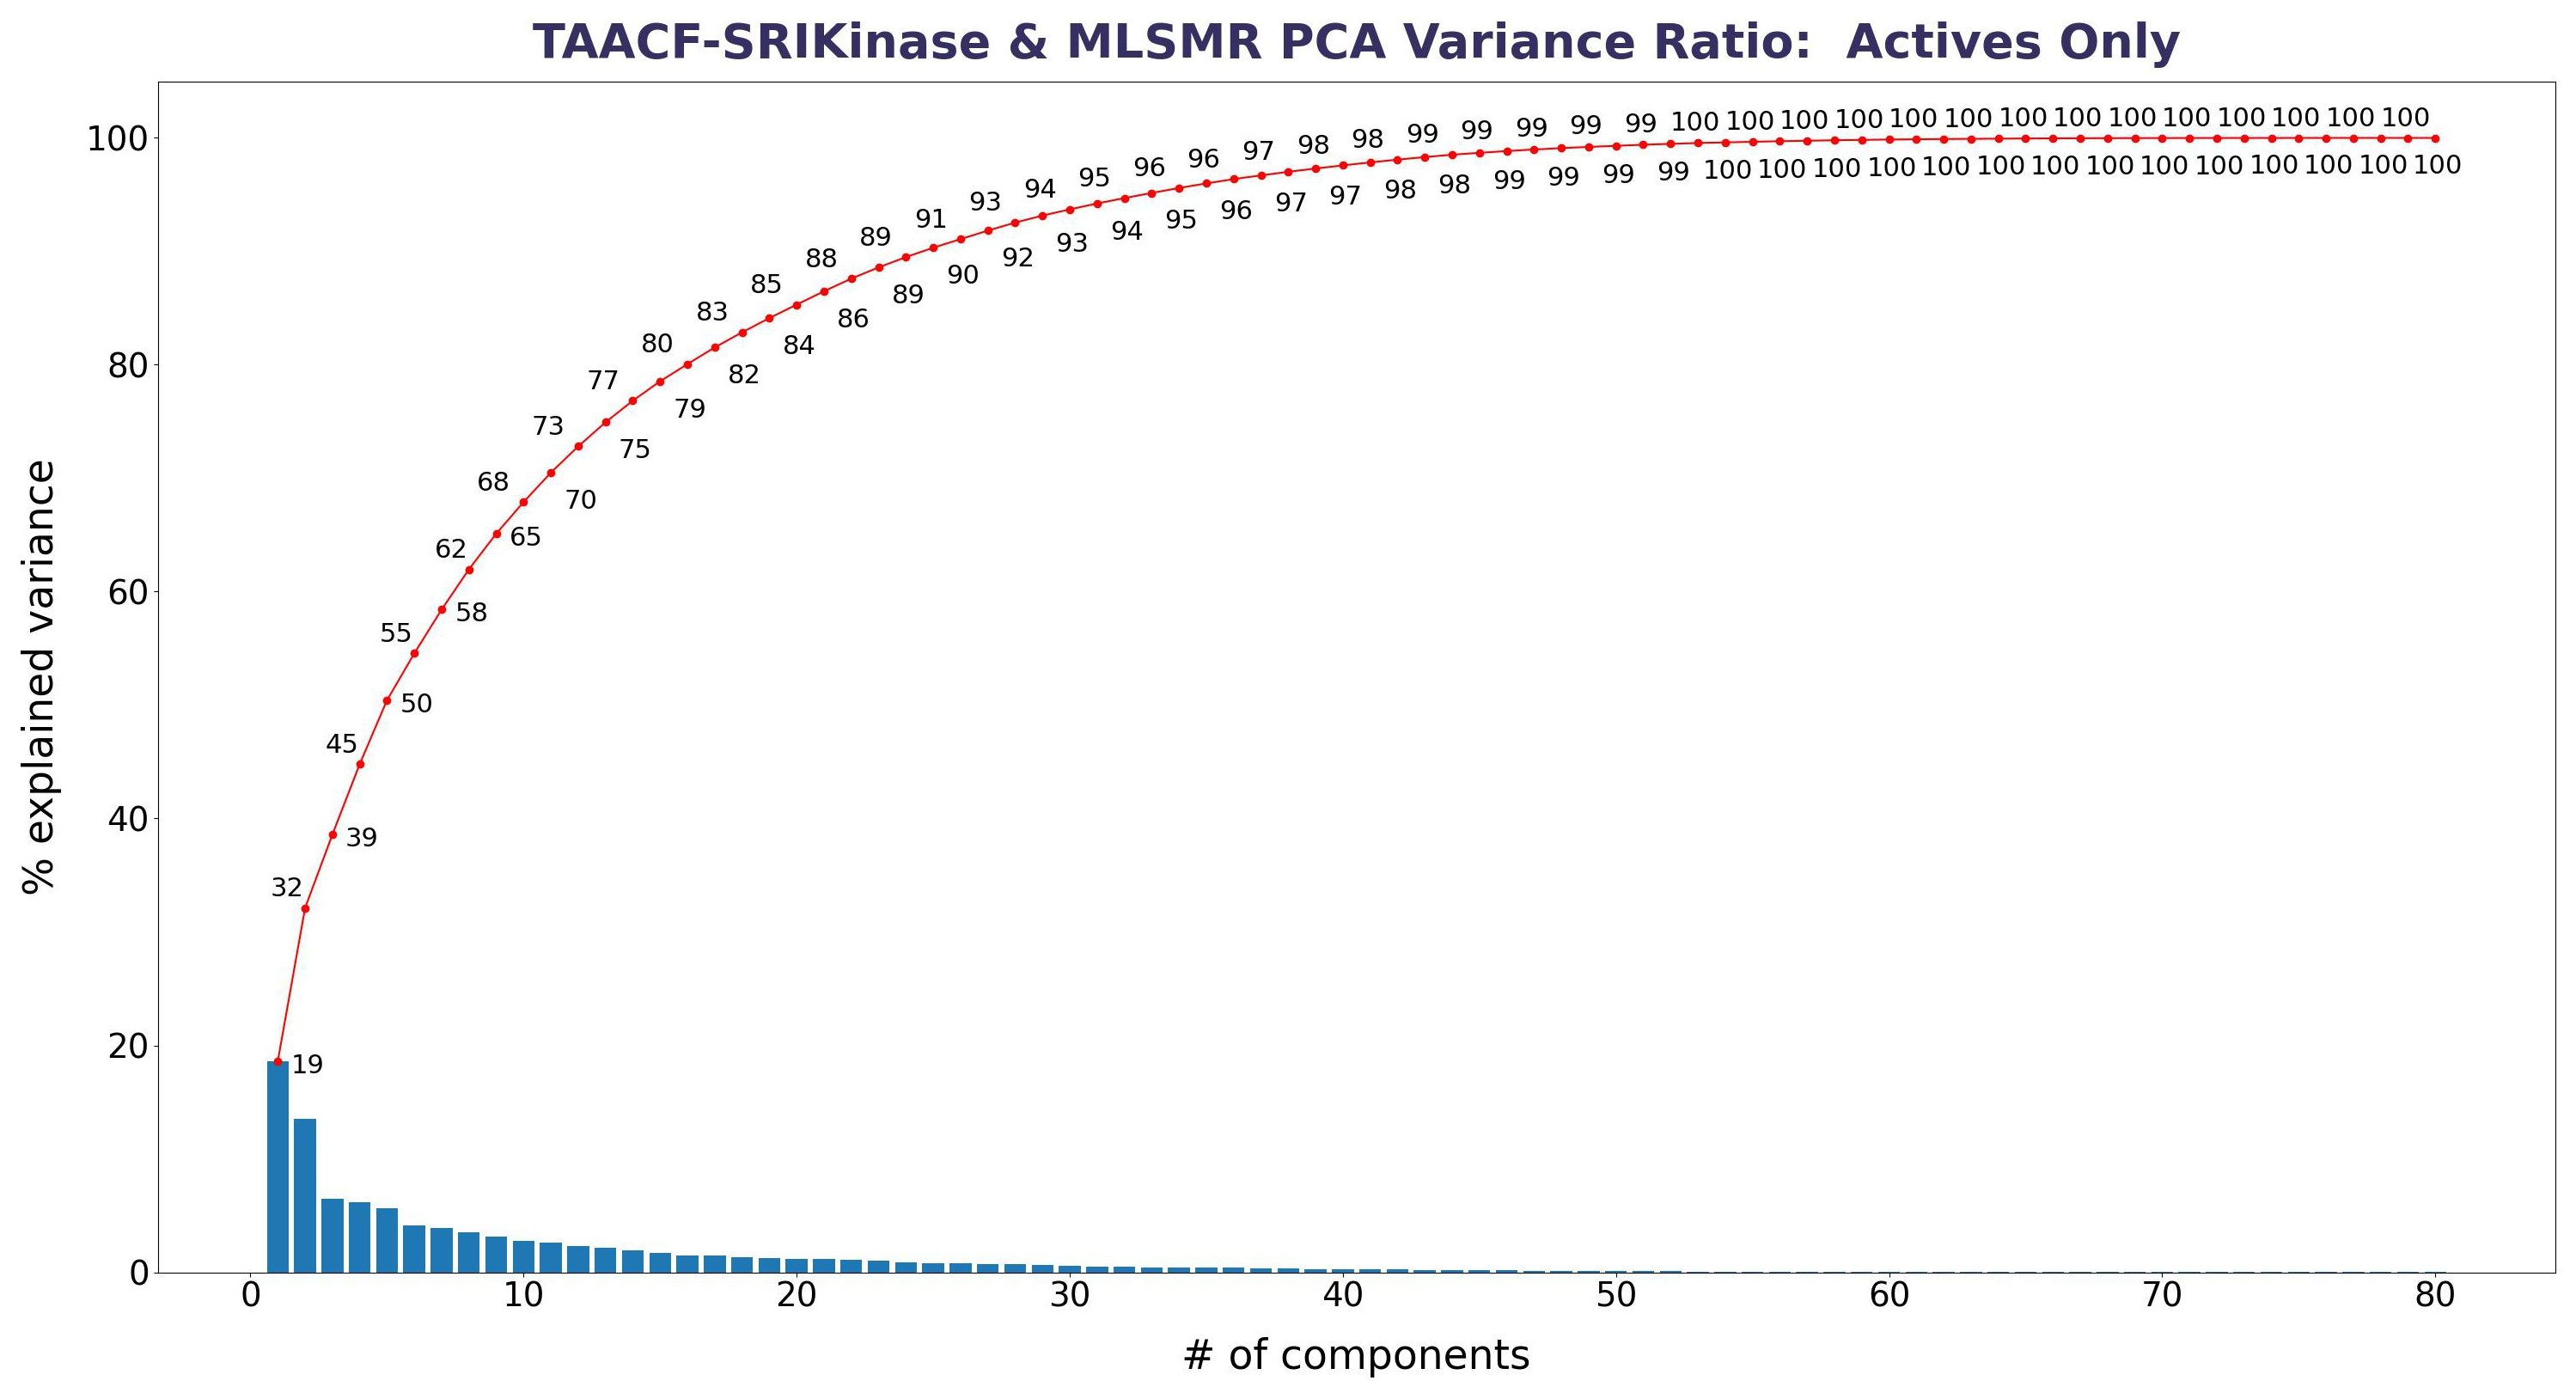

In [167]:
# fit PCA without reducing the number of components for both Actives/Inactives, and Actives only
# see how much of the variance each component explains

titles = ['TAACF-SRIKinase PCA Variance Ratio', 'TAACF-SRIKinase PCA Variance Ratio'
    , 'MLSMR PCA Variance Ratio', 'MLSMR PCA Variance Ratio', 'TAACF-SRIKinase & MLSMR PCA Variance Ratio']
subtitles = ['Active and Inactives', 'Actives Only', 'Active and Inactives', 'Actives Only', 'Actives Only']
filenames = [f'{image_path_pca}PCA_VarianceRatio_All{suffix_TAACF}', f'{image_path_pca}PCA_VarianceRatio_Active{suffix_TAACF}'
    , f'{image_path_pca}PCA_VarianceRatio_All{suffix_MLSMR}', f'{image_path_pca}PCA_VarianceRatio_Active{suffix_MLSMR}'
    , f'{image_path_pca}PCA_VarianceRatio_Active{suffix_TAACF}_n{suffix_MLSMR}']
x_data = [data_features_taacf, data_taacf_active_, data_features_mlsmr, data_mlsmr_active_, data_active_feature]

diredux.get_pca(titles, subtitles, filenames, x_data)

##### &nbsp;&nbsp;&nbsp;4.2&nbsp;&nbsp;Variance Ratio Table 

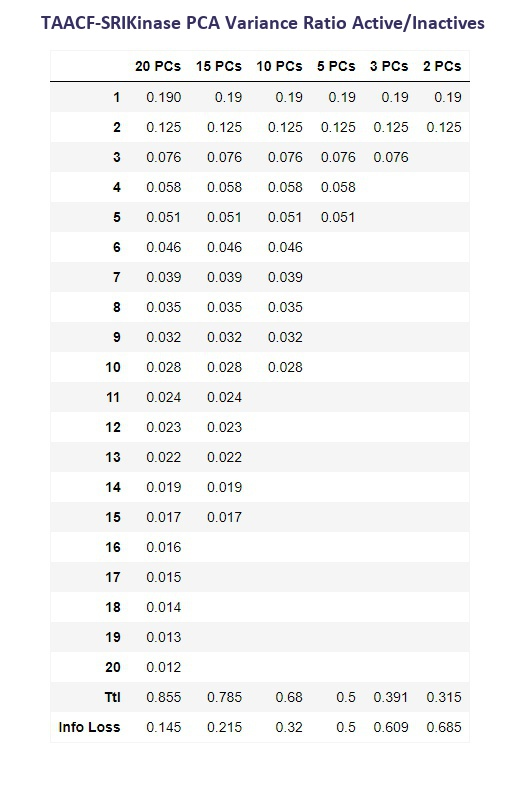

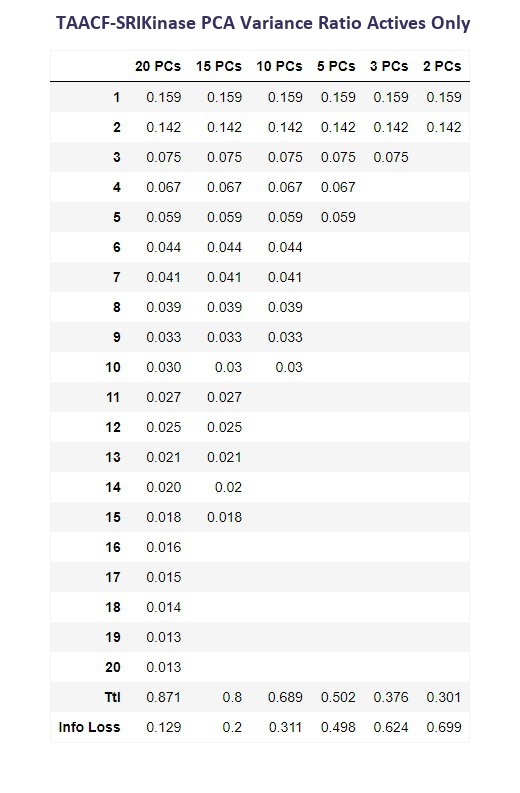

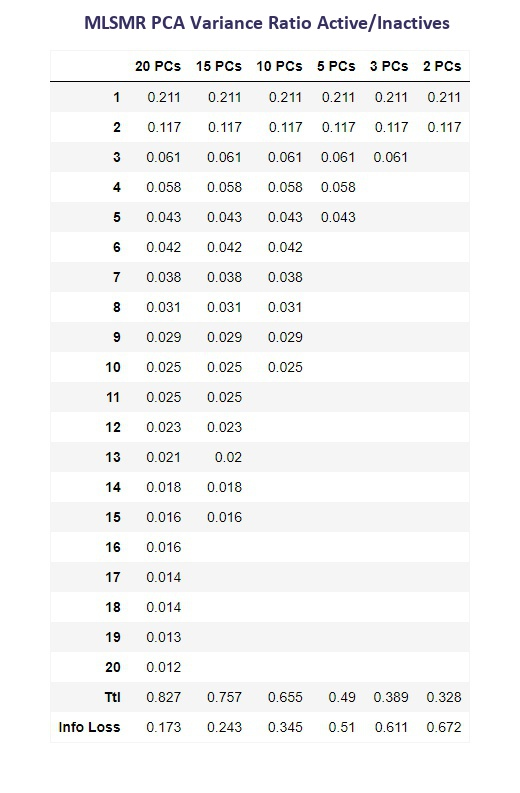

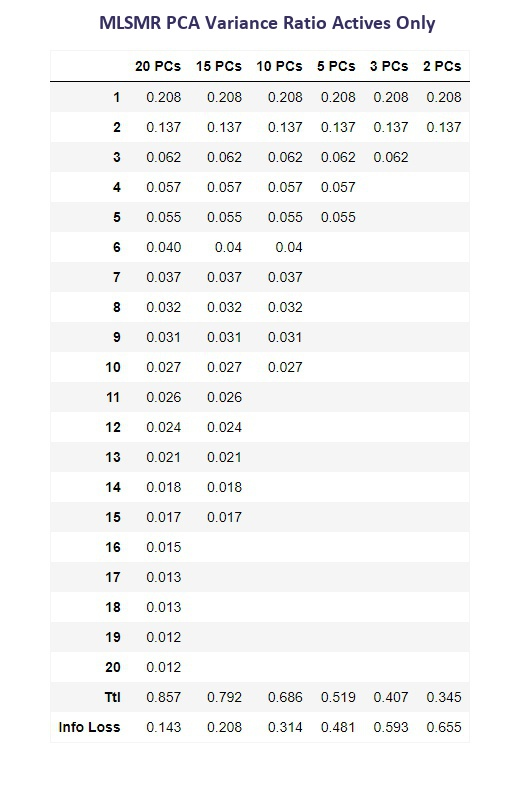

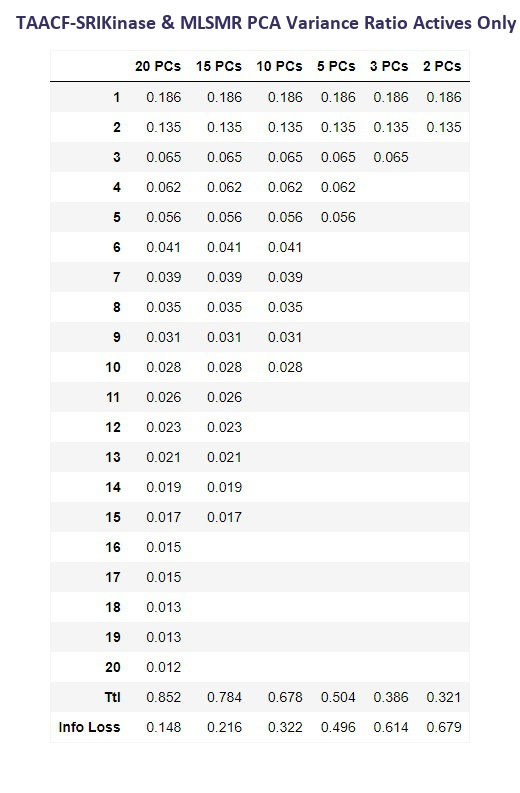

In [112]:
# set # of pc to check
pc_nums = [5, 3, 2, 10, 15, 20]
titles = ['TAACF-SRIKinase PCA Variance Ratio Active/Inactives'
    , 'TAACF-SRIKinase PCA Variance Ratio Actives Only'
    , 'MLSMR PCA Variance Ratio Active/Inactives', 'MLSMR PCA Variance Ratio Actives Only'
    , 'TAACF-SRIKinase & MLSMR PCA Variance Ratio Actives Only']
filenames = [f'PCA_VarianceRatio_Table_All{suffix_TAACF}'
    , f'PCA_VarianceRatio_Table_Active{suffix_TAACF}'
    , f'PCA_VarianceRatio_Table_All{suffix_MLSMR}'
    , f'PCA_VarianceRatio_Table_Active{suffix_MLSMR}'
    , f'PCA_VarianceRatio_Table_ctive{suffix_TAACF}_n{suffix_MLSMR}']
x_data = [data_features_taacf, data_taacf_active_, data_features_mlsmr, data_mlsmr_active_, data_active_feature]

diredux.run_pca(pc_nums, titles, filenames, x_data, image_path_pca, data_path_pca, font_path)

##### &nbsp;&nbsp;&nbsp;4.3&nbsp;&nbsp;Plot PCA:  2D

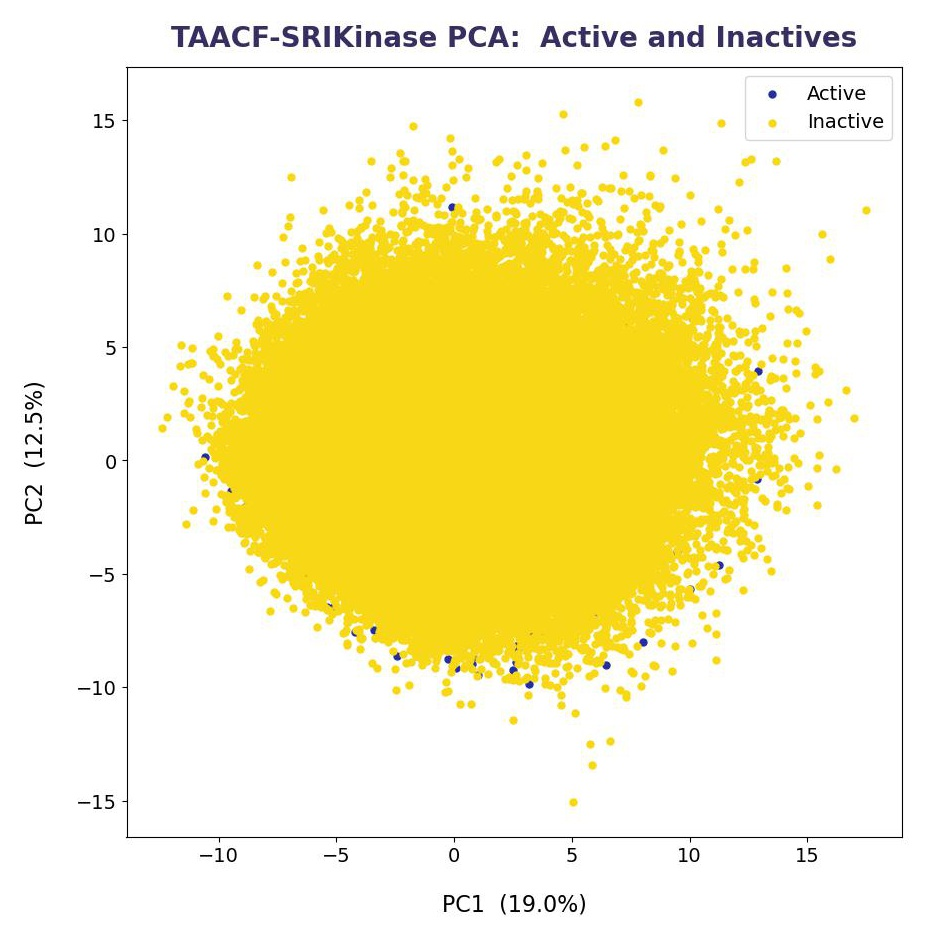

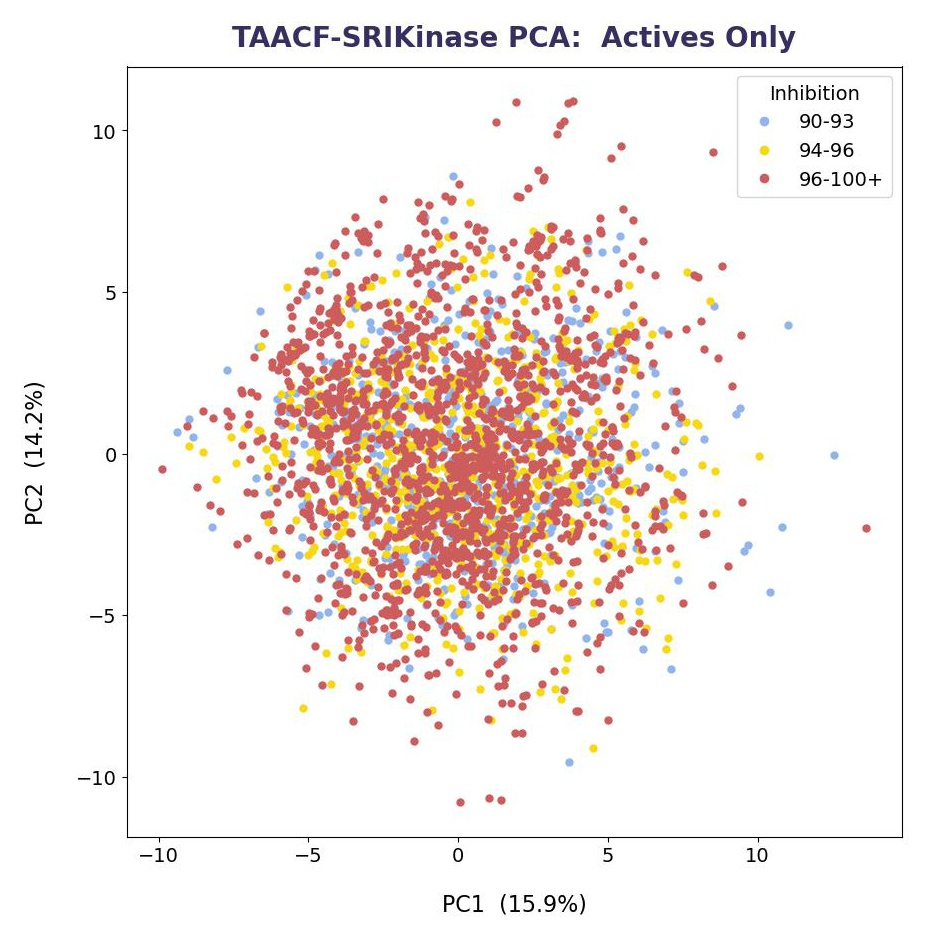

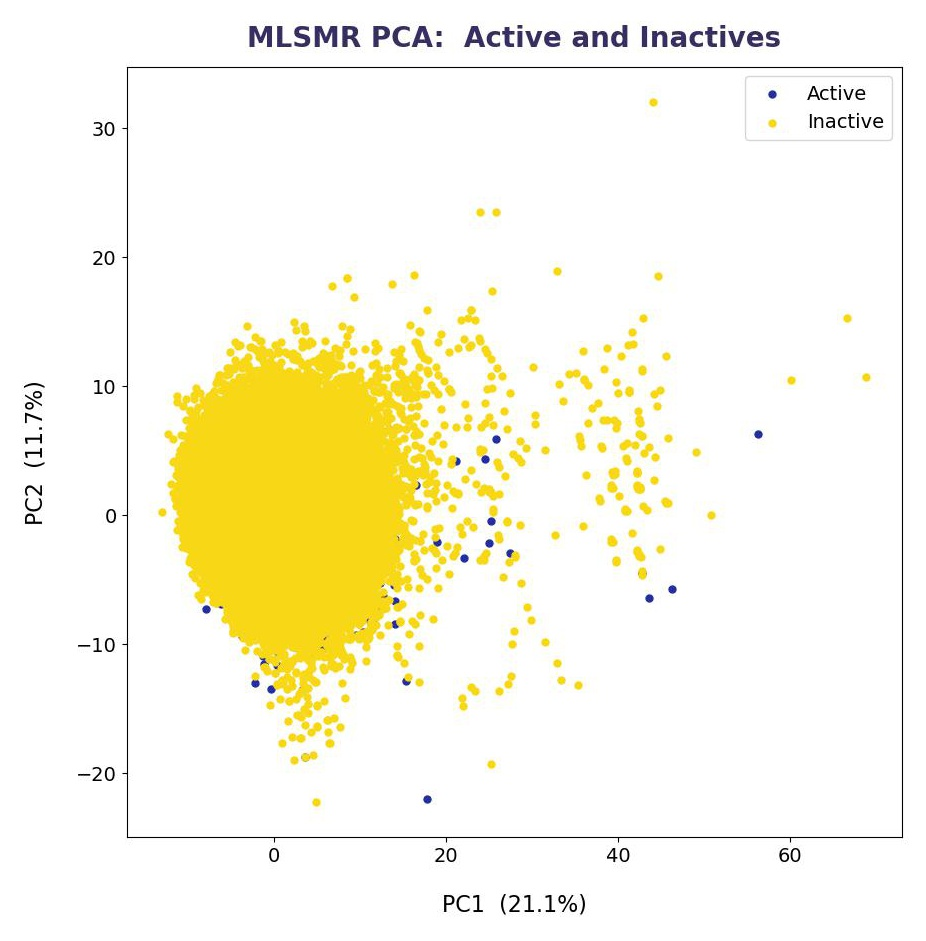

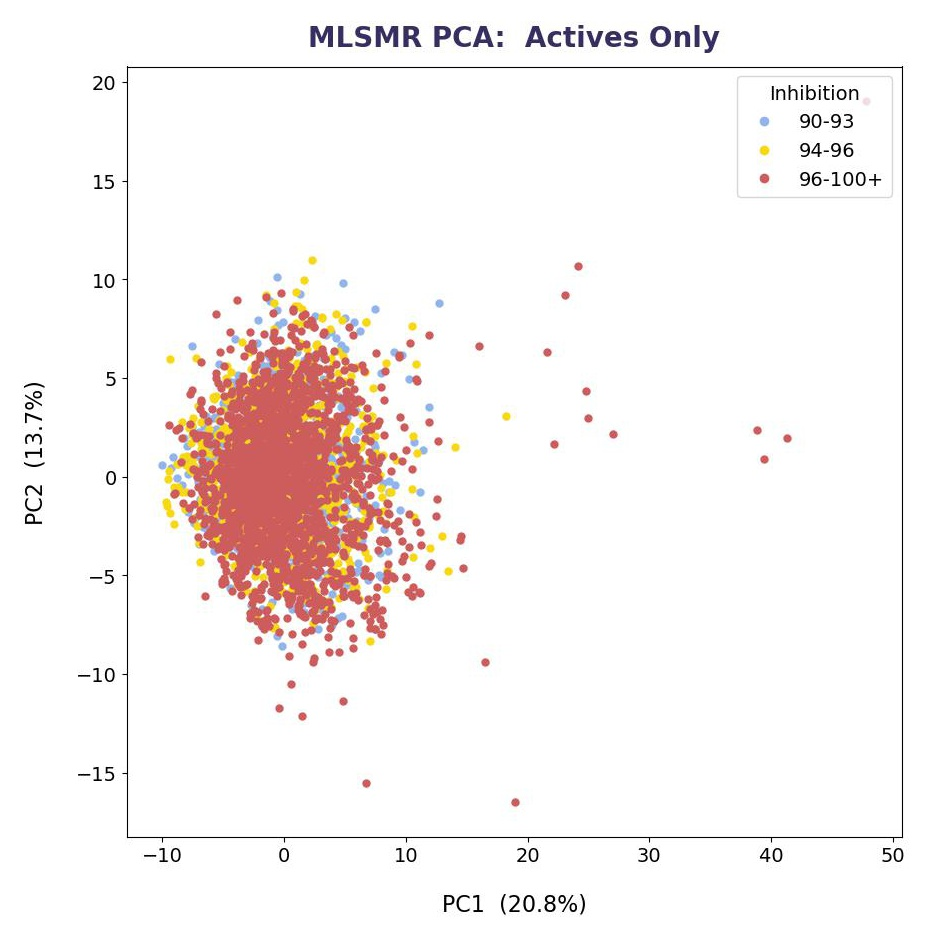

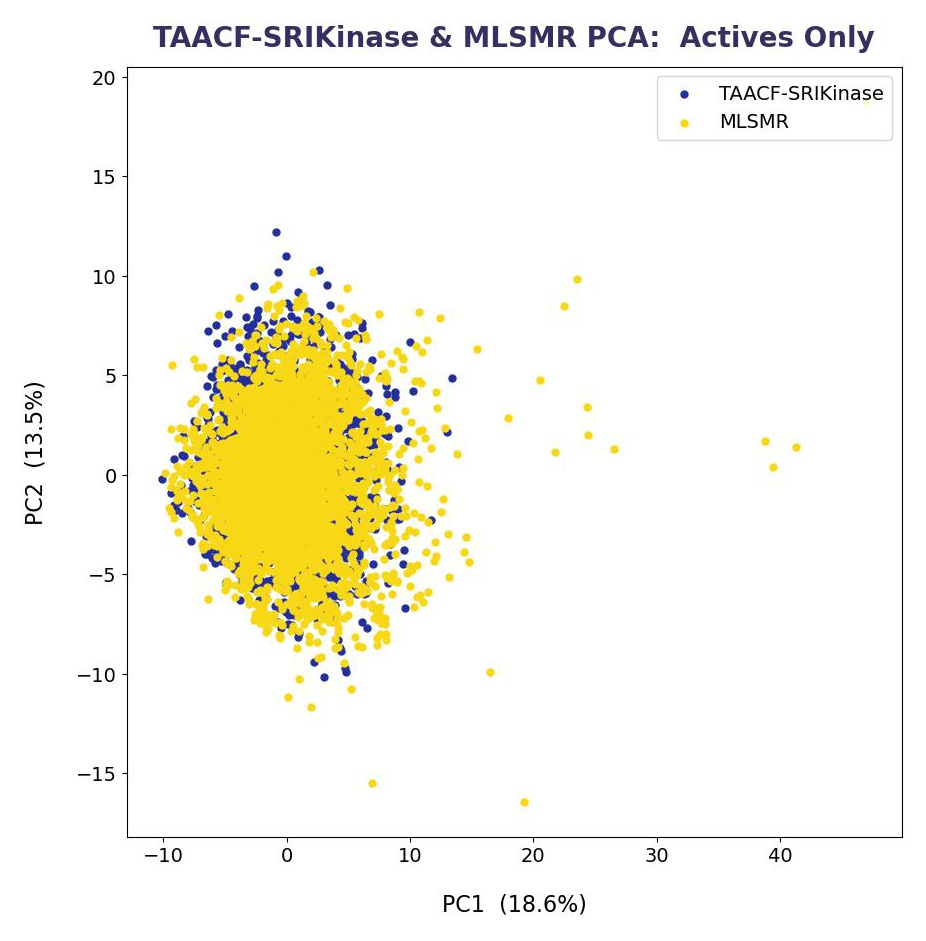

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [169]:
#run pca
pc_num = 2
XPC = 'PC1'
YPC = 'PC2'
ZPC = 'PC3'

# set # of pc to check
titles = ['TAACF-SRIKinase PCA:  Active and Inactives', 'TAACF-SRIKinase PCA:  Actives Only'
    , 'MLSMR PCA:  Active and Inactives', 'MLSMR PCA:  Actives Only'
    , 'TAACF-SRIKinase & MLSMR PCA:  Actives Only']
filenames = [f'{image_path_pca}PCA2D_All{suffix_TAACF}', f'{image_path_pca}PCA2D_Active{suffix_TAACF}'
    , f'{image_path_pca}PCA2D_All{suffix_MLSMR}', f'{image_path_pca}PCA2D_Active{suffix_MLSMR}'
    , f'{image_path_pca}PCA2D_Active{suffix_TAACF}_n{suffix_MLSMR}']

x_data = [data_features_taacf, data_taacf_active_, data_features_mlsmr, data_mlsmr_active_
    , data_active_feature]
x_data_inhibits = [None, data_taacf_active_inhibit, None, data_mlsmr_active_inhibit, None]
y_data = [data_y_taacf[col_Activity].to_numpy(), data_taacf_active_y.to_numpy()
    , data_y_mlsmr[col_Activity].to_numpy(), data_mlsmr_active_y.to_numpy()
    , data_active_origin.to_numpy()]

features = [data_features_taacf.columns, data_taacf_active_.columns
    , data_features_mlsmr.columns, data_mlsmr_active_.columns, data_active_feature.columns]
legends = [['Active', 'Inactive'], ['Active'], ['Active', 'Inactive'], ['Active']
    , ['TAACF-SRIKinase', 'MLSMR']]
targets = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 2]]

diredux.plot_pca(pc_num, XPC, YPC, ZPC, titles, filenames, x_data, x_data_inhibits, y_data
    , features, legends, targets, image_path)

##### &nbsp;&nbsp;&nbsp;4.4&nbsp;&nbsp;Plot PCA:  3D

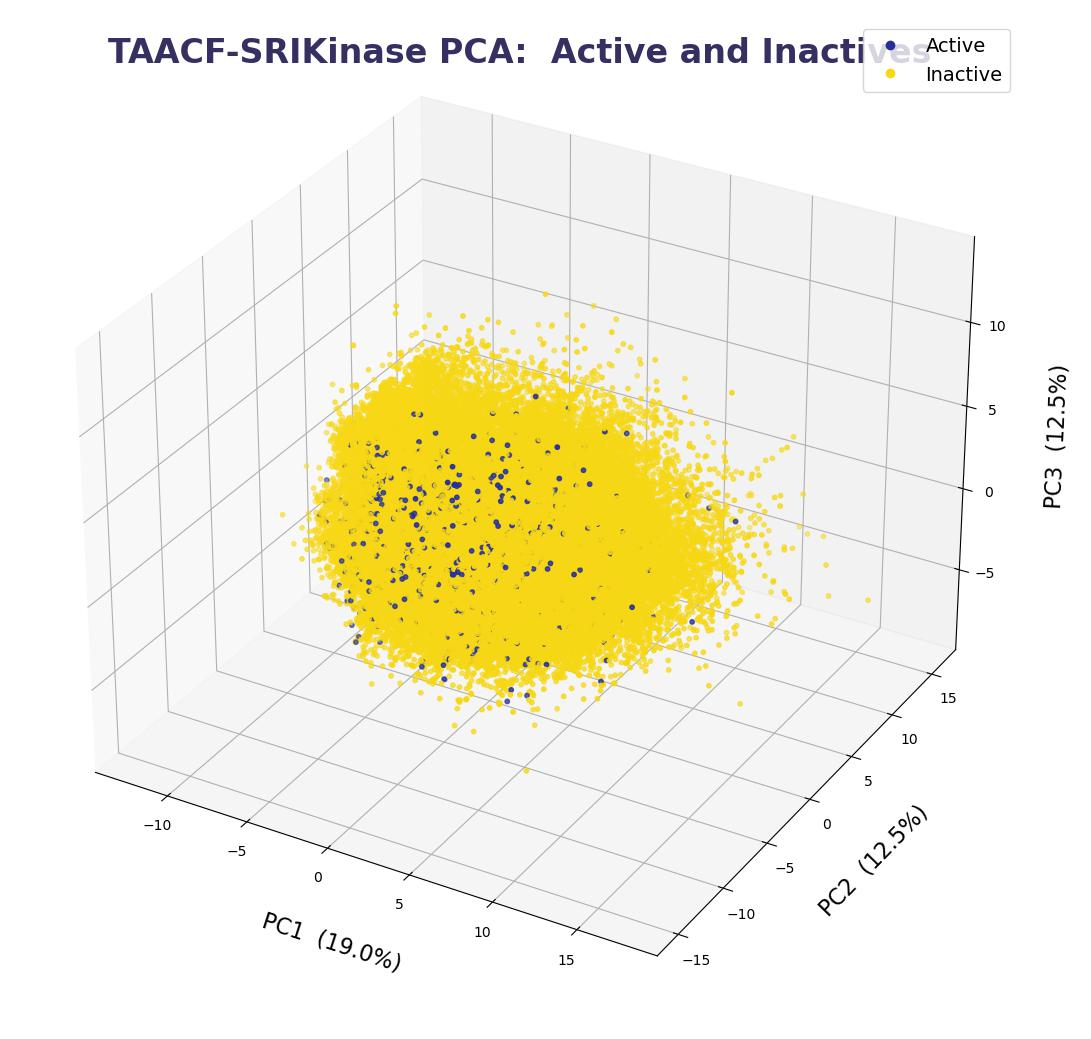

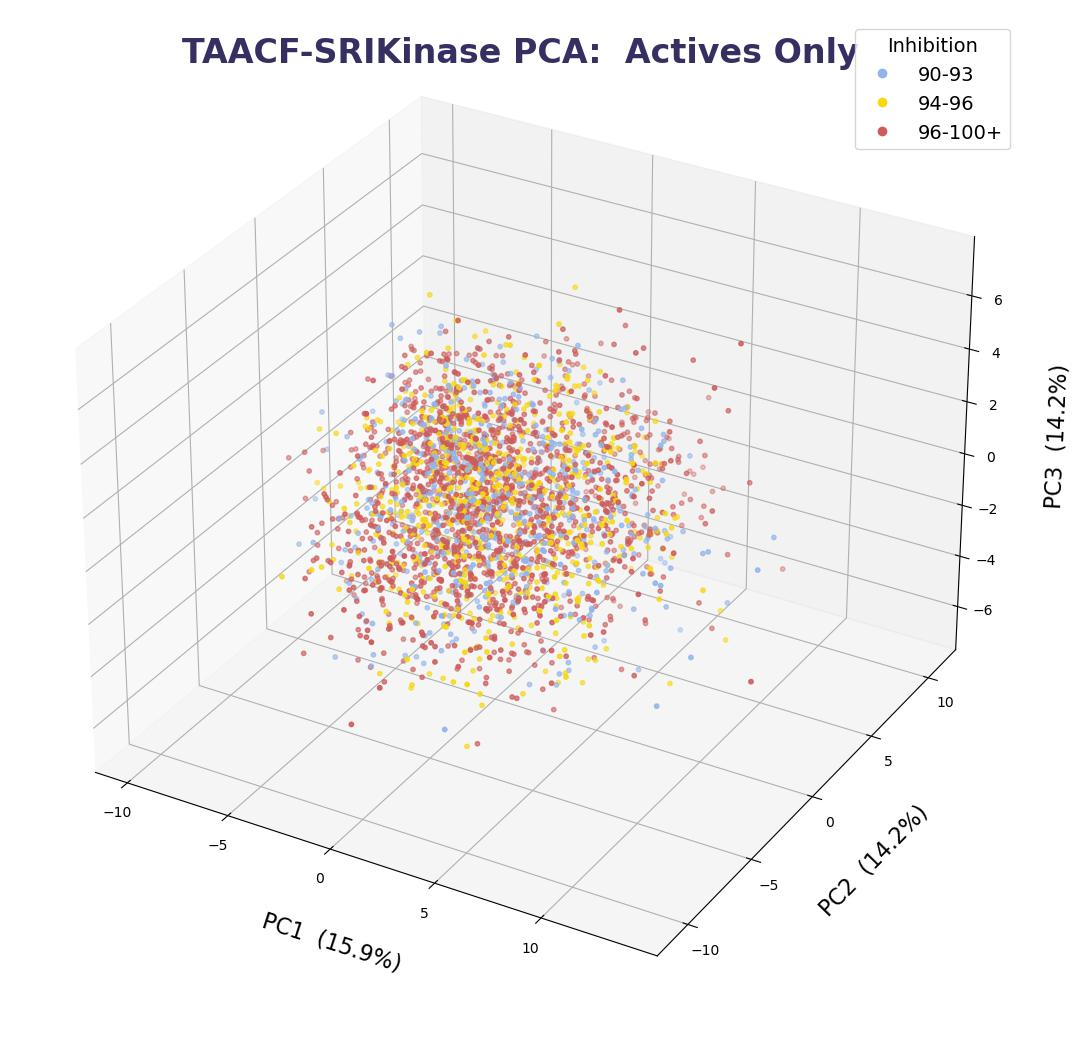

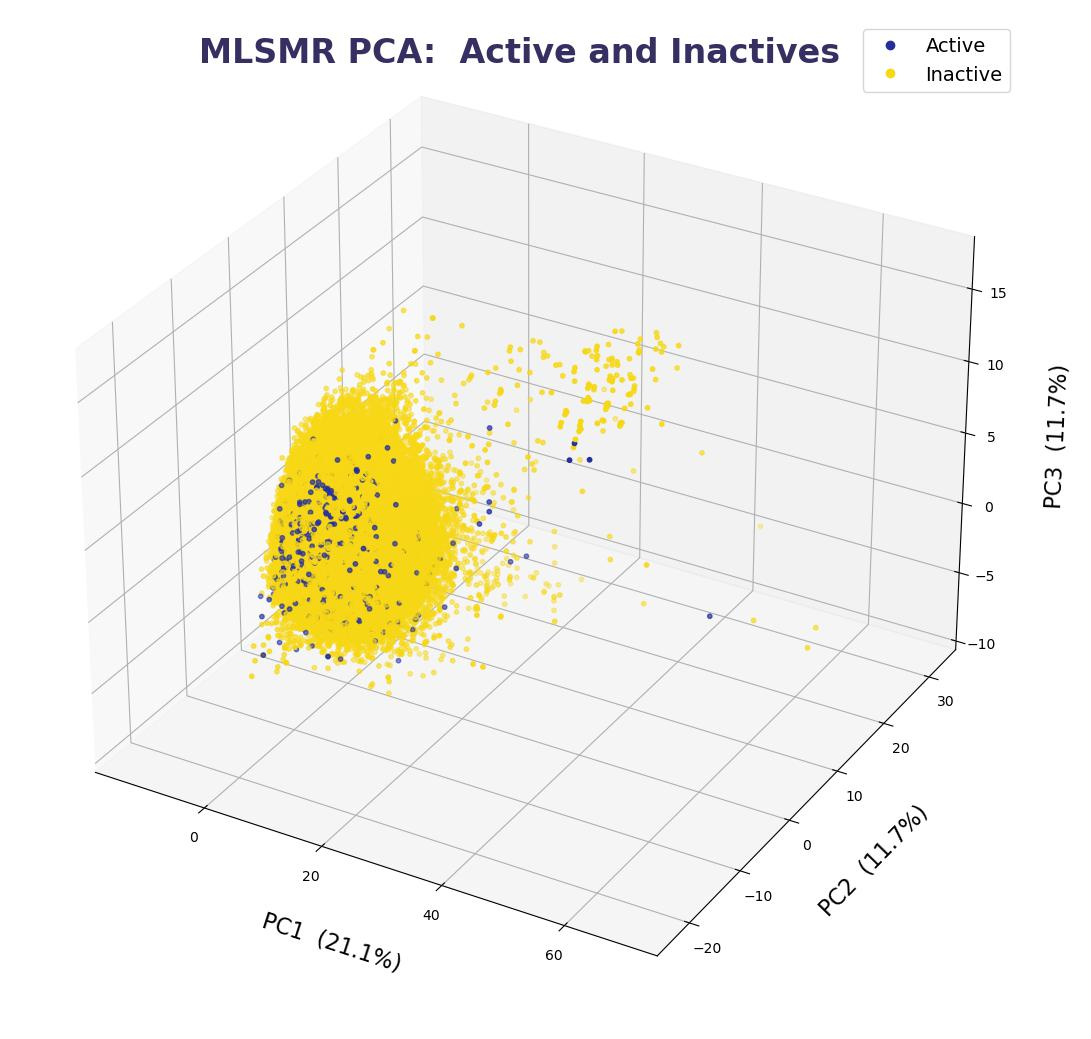

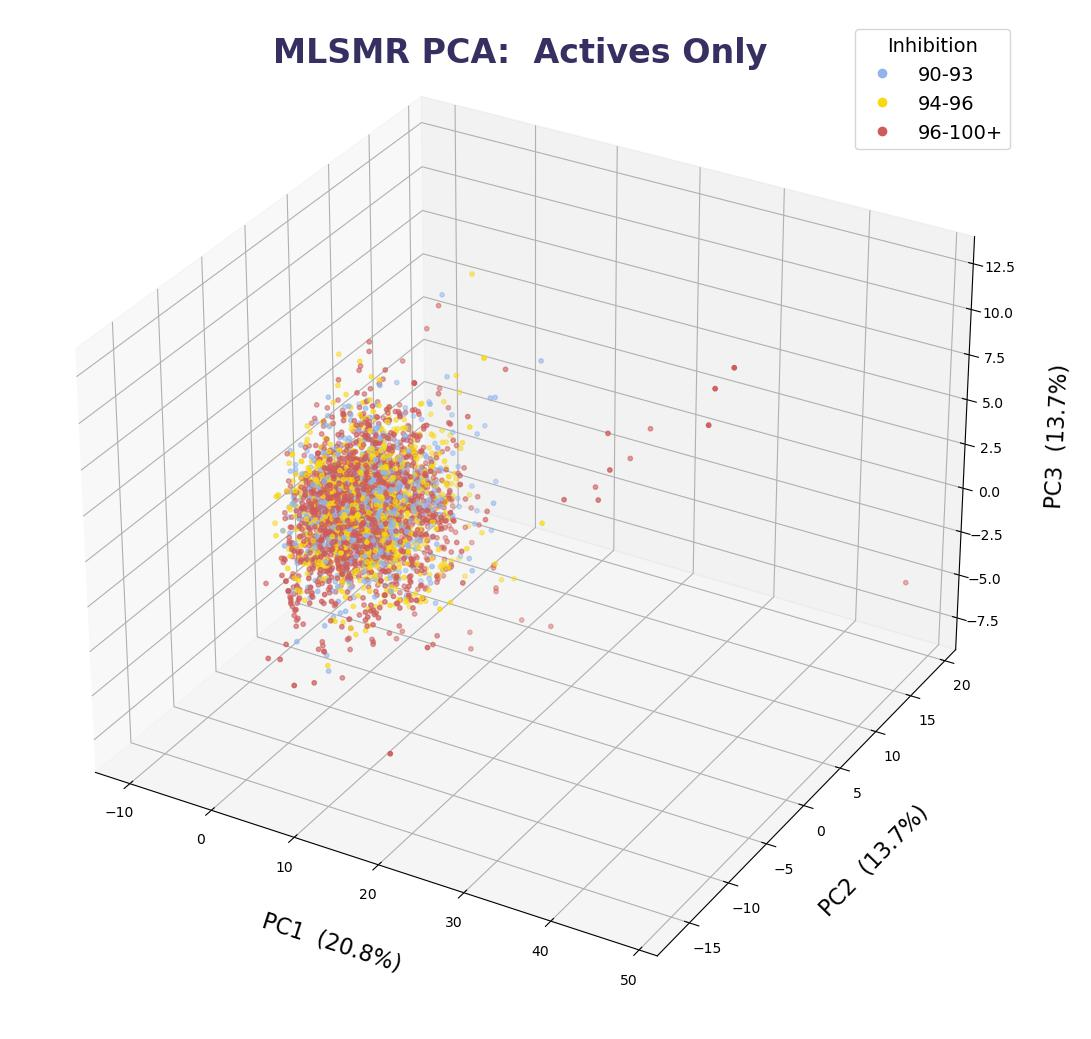

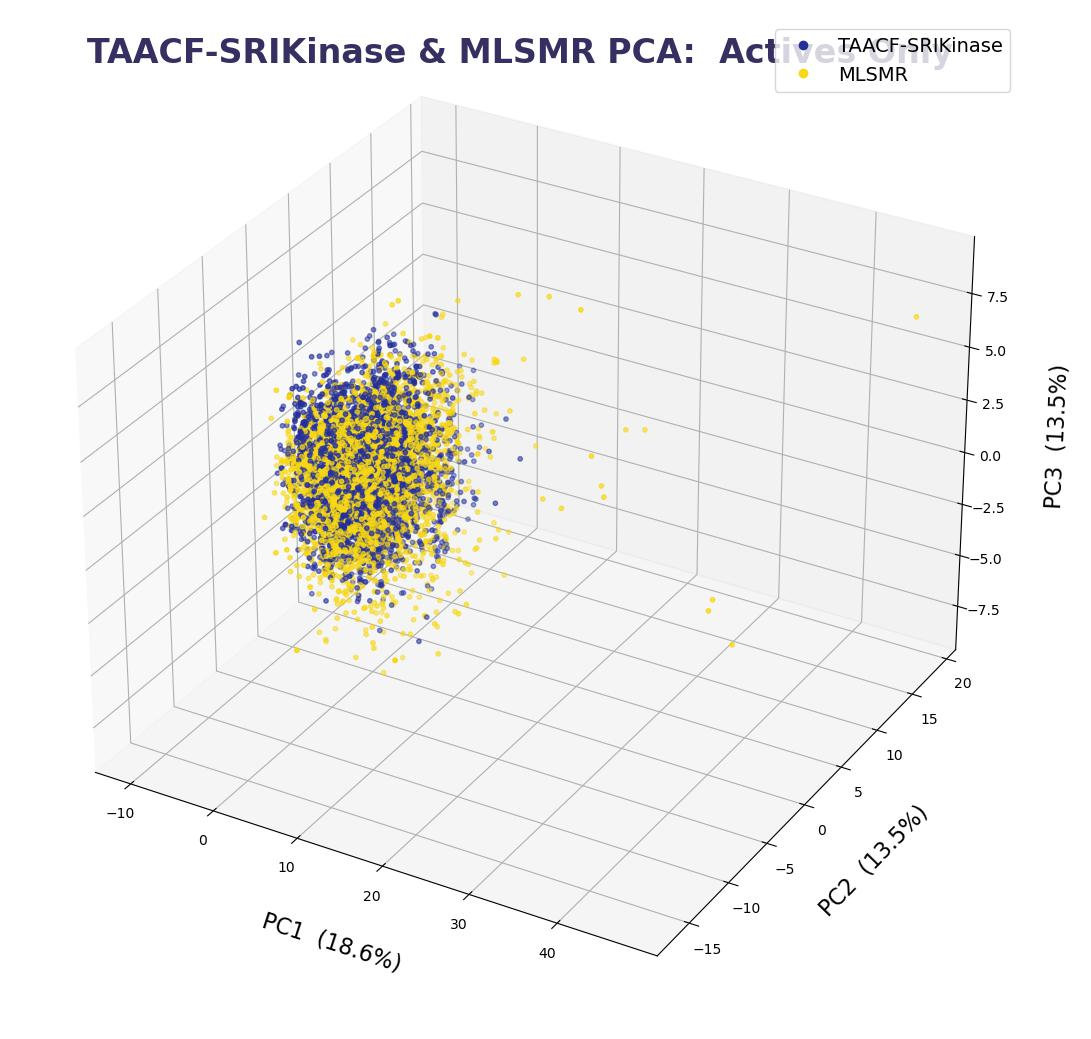

In [170]:
pc_num = 3
targets = legends
filenames = [f'{image_path_pca}PCA3D_All{suffix_TAACF}', f'{image_path_pca}PCA3D_Active{suffix_TAACF}'
    , f'{image_path_pca}PCA3D_All{suffix_MLSMR}', f'{image_path_pca}PCA3D_Active{suffix_MLSMR}'
    , f'{image_path_pca}PCA3D_Active{suffix_TAACF}_n{suffix_MLSMR}']

diredux.plot_pca(pc_num, XPC, YPC, ZPC, titles, filenames, x_data, x_data_inhibits, y_data
    , features, legends, targets, image_path)

#### 5.  UMAP

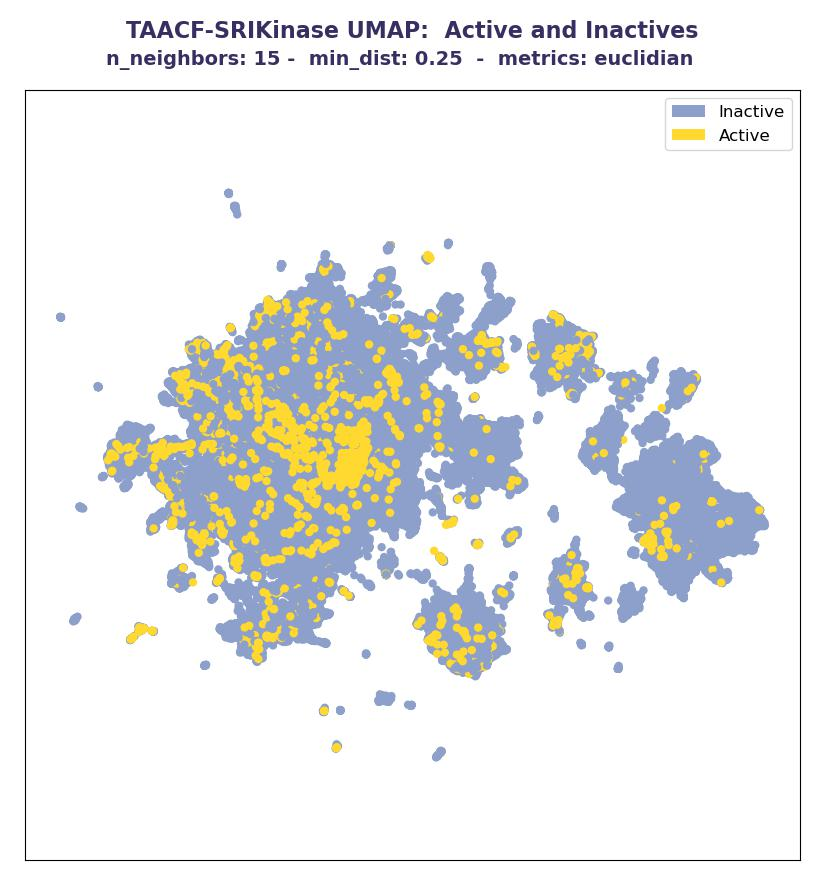

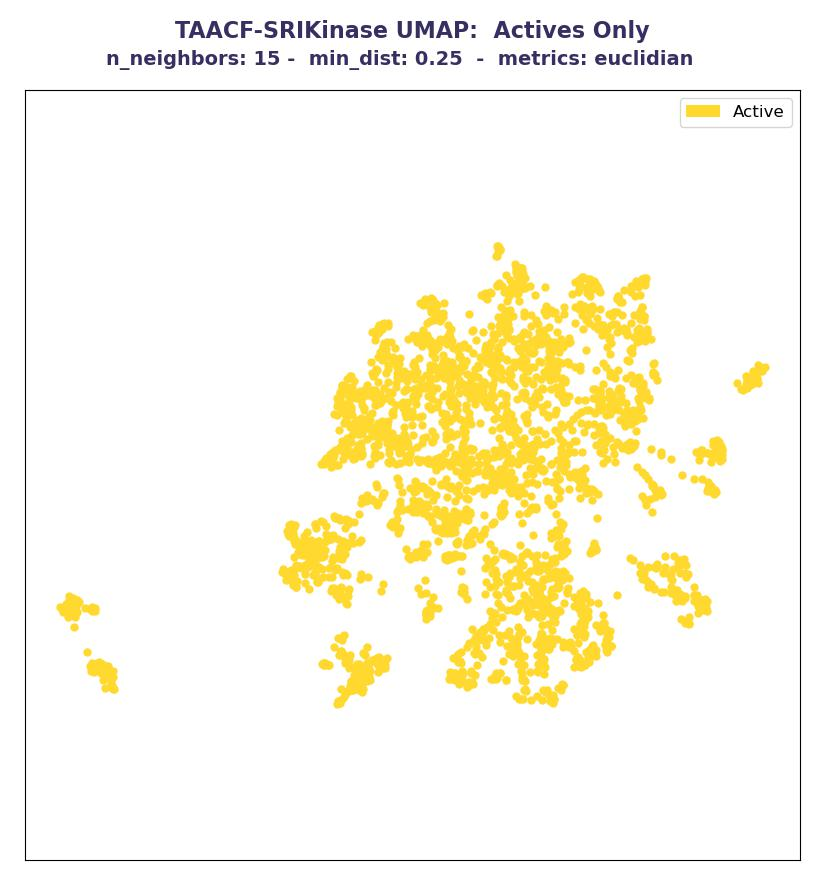

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


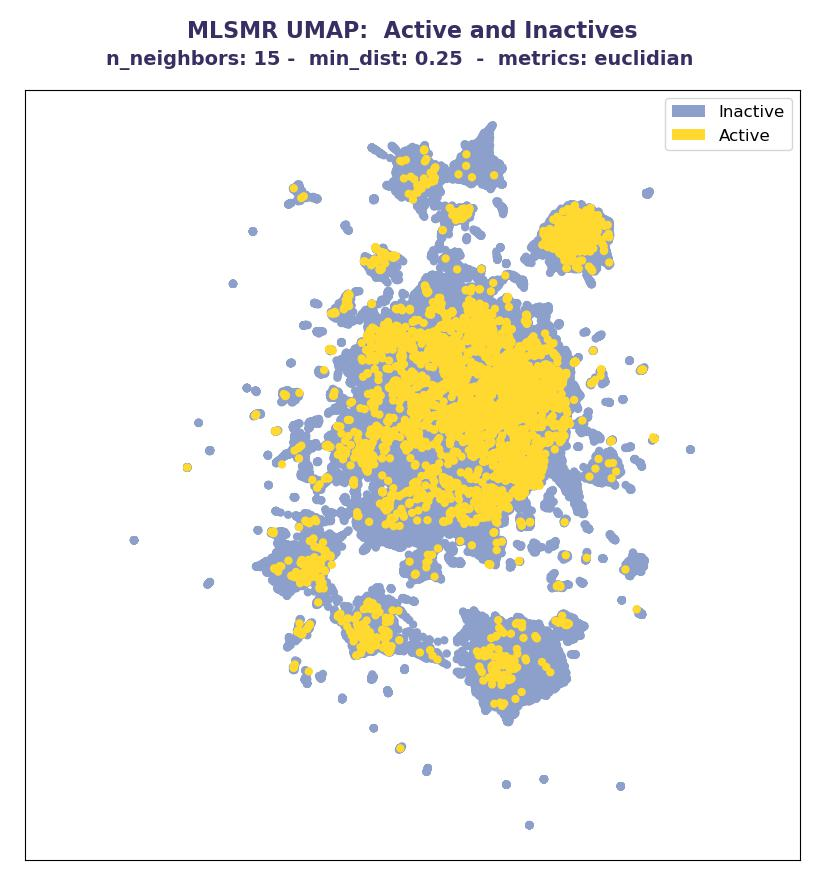

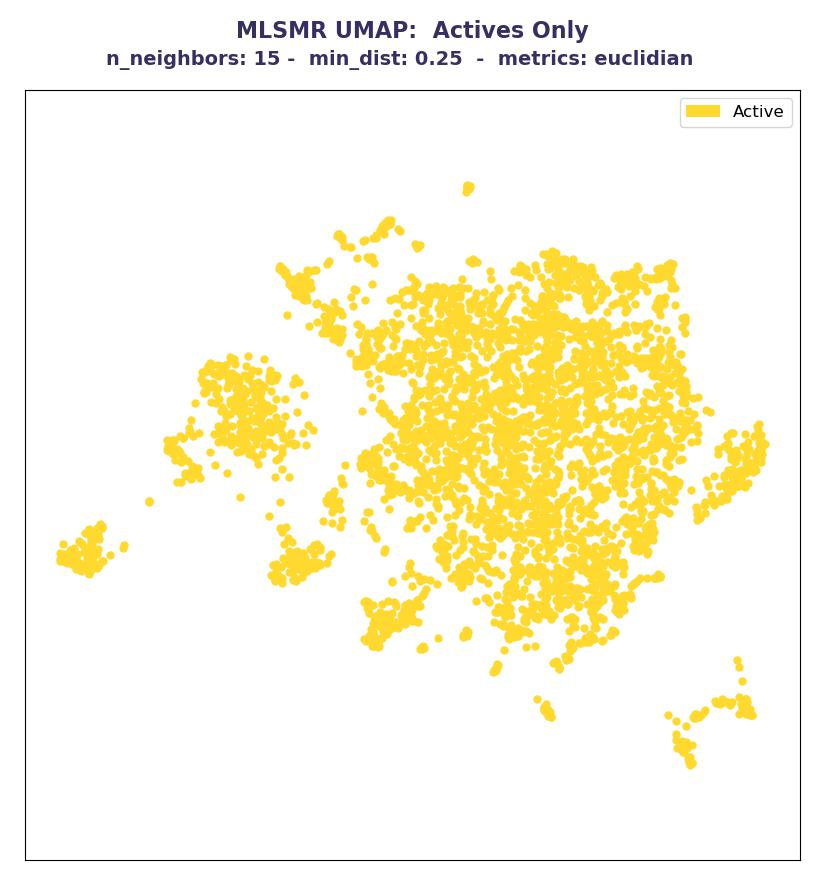

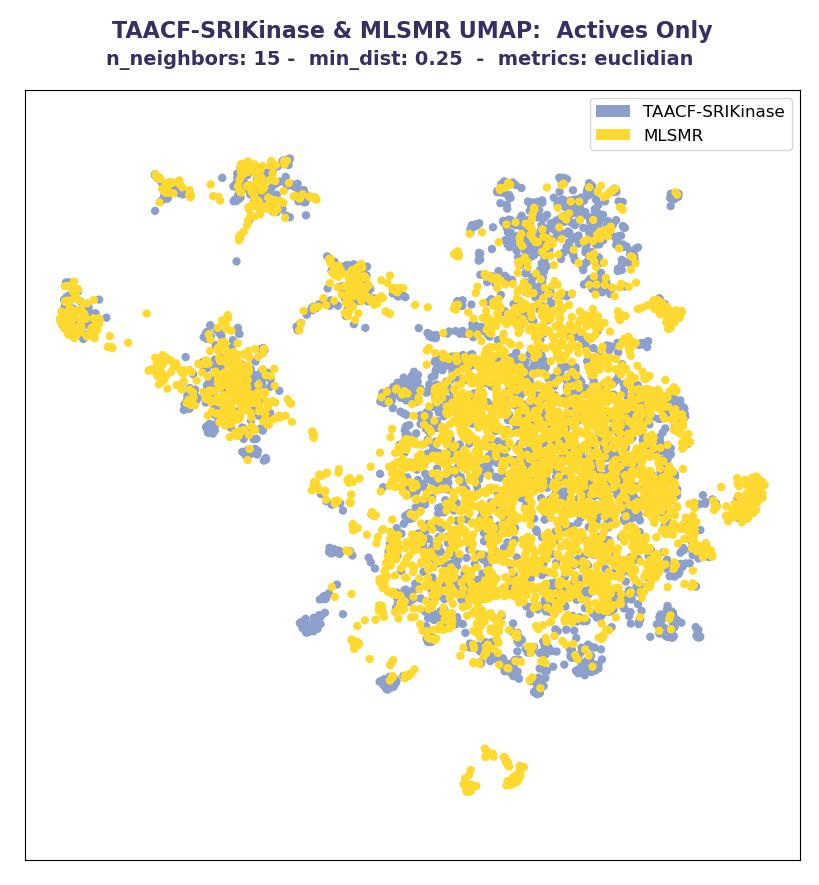

In [186]:
titles = ['TAACF-SRIKinase UMAP:  Active and Inactives', 'TAACF-SRIKinase UMAP:  Actives Only'
    , 'MLSMR UMAP:  Active and Inactives', 'MLSMR UMAP:  Actives Only'
    , 'TAACF-SRIKinase & MLSMR UMAP:  Actives Only']
filenames = [f'UMAP_All{suffix_TAACF}', f'UMAP_Active{suffix_TAACF}'
    , f'UMAP_All{suffix_MLSMR}', f'UMAP_Active{suffix_MLSMR}'
    , f'UMAP_Active{suffix_TAACF}_n{suffix_MLSMR}']

x_data = [data_features_taacf, data_taacf_active_, data_features_mlsmr, data_mlsmr_active_
    , data_active_feature]
y_data = [data_y_taacf[col_Activity].to_numpy(), data_taacf_active_y.to_numpy()
    , data_y_mlsmr[col_Activity].to_numpy(), data_mlsmr_active_y.to_numpy()
    , data_active_origin.to_numpy()]
class_list = [['Inactive', 'Active'], ['Active'], ['Inactive', 'Active'], ['Active'], ['TAACF-SRIKinase', 'MLSMR']]
class_colours = [{0:'#8DA0CB', 1:'#FFD92F'}, {1:'#FFD92F'}, {0:'#8DA0CB', 1:'#FFD92F'}, {1:'#FFD92F'}, {1:'#8DA0CB', 2:'#FFD92F'}]

n_neighbors = 15
min_dist = 0.25
metrics = 'euclidean'

diredux.get_umap(n_neighbors, min_dist, metrics, titles, filenames, x_data, y_data
    , class_list, class_colours
    , path_image=image_path_umap, path_model=model_path, path_data=data_path_umap)

#### 6.  tSNE

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


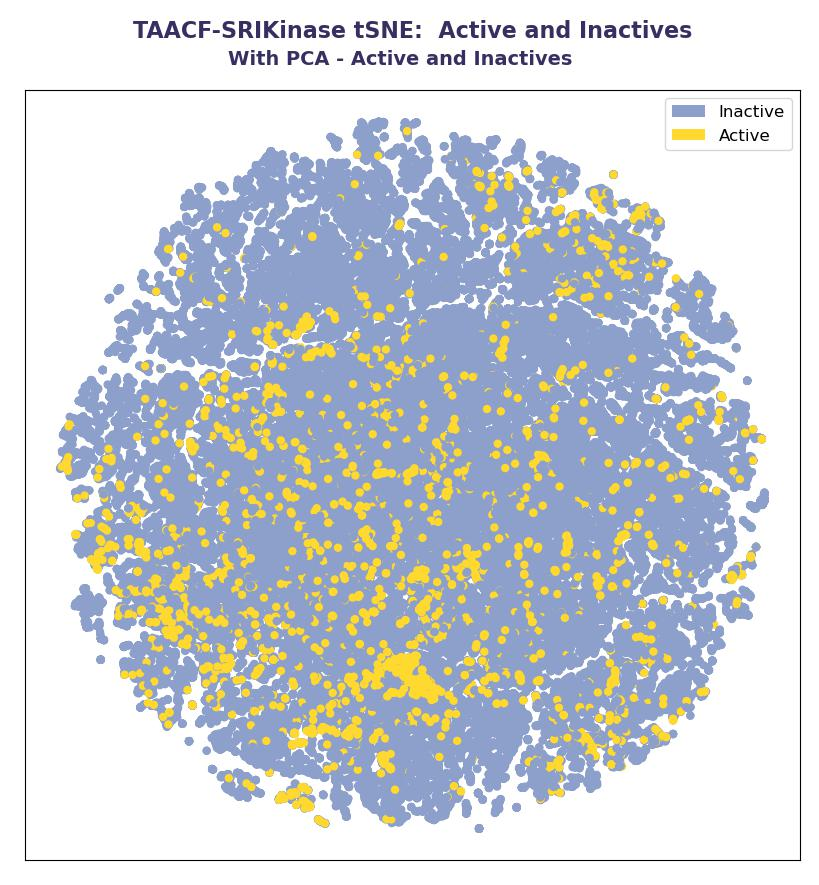

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


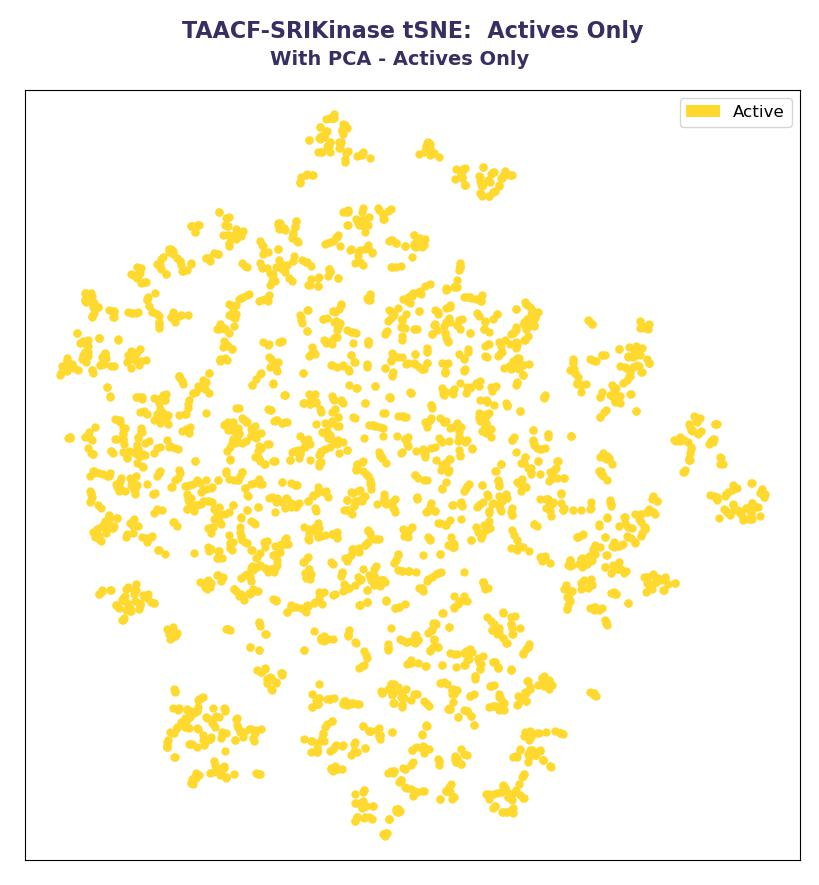

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [198]:
titles = ['TAACF-SRIKinase tSNE:  Active and Inactives', 'TAACF-SRIKinase tSNE:  Actives Only'
    , 'MLSMR tSNE:  Active and Inactives', 'MLSMR tSNE:  Actives Only'
    , 'TAACF-SRIKinase & MLSMR tSNE:  Actives Only']
subtitles = ['With PCA - Active and Inactives', 'With PCA - Actives Only'
    , 'With PCA - Active and Inactives', 'With PCA - Actives Only'
    , 'With PCA - Actives Only']
filenames = [f'tSNE_All{suffix_TAACF}', f'tSNE_Active{suffix_TAACF}'
    , f'tSNE_All{suffix_MLSMR}', f'tSNE_Active{suffix_MLSMR}'
    , f'tSNE_Active{suffix_TAACF}_n{suffix_MLSMR}']

x_data = [data_features_taacf, data_taacf_active_, data_features_mlsmr, data_mlsmr_active_
    , data_active_feature]
y_data = [data_y_taacf[col_Activity].to_numpy(), data_taacf_active_y.to_numpy()
    , data_y_mlsmr[col_Activity].to_numpy(), data_mlsmr_active_y.to_numpy()
    , data_active_origin.to_numpy()]
data_smiles = [data_molecules_taacf[col_smiles], data_taacf_active_smiles
    , data_molecules_mlsmr[col_smiles], data_mlsmr_active_smiles
    , data_active_smiles]
data_inhibit = [data_molecules_taacf[col_inhibition], data_taacf_active_inhibit
    , data_molecules_mlsmr[col_inhibition], data_mlsmr_active_inhibit
    , data_active_inhibit]

class_list = [['Inactive', 'Active'], ['Active'], ['Inactive', 'Active'], ['Active'], ['TAACF-SRIKinase', 'MLSMR']]
class_colours = [{0:'#8DA0CB', 1:'#FFD92F'}, {1:'#FFD92F'}, {0:'#8DA0CB', 1:'#FFD92F'}, {1:'#FFD92F'}, {1:'#8DA0CB', 2:'#FFD92F'}]

getSavedModels = [0, 0, 0, 0, 0]
pc_num = 20
perplexity = 10
iterations = 1000
learning_rate = 200

diredux.get_tsne(pc_num, perplexity, iterations, learning_rate
    , titles, subtitles, filenames, x_data, y_data, data_smiles, data_inhibit
    , class_list, class_colours, getSavedModels
    , path_image=image_path_umap, path_model=model_path, path_data=data_path_umap)